# Continuous Control

---
Solving the BipedalWalker-v3 environment, using PPO

In [ ]:
#PPO 1 neural network

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Actor_Critic(nn.Module):

    def __init__(self, state_size, action_size, seed):

        super(Actor_Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        #self.bn1 = nn.BatchNorm1d(64)
        #self.fc2 = nn.Linear(64, 64)
        #self.bn2 = nn.BatchNorm1d(64)
        #self.fc3 = nn.Linear(300, 32)
        #self.bn3 = nn.BatchNorm1d(32)
        
        #action
        self.fc1a = nn.Linear(state_size, 64)
        self.fc2a = nn.Linear(64, 64)
        #self.fc3a = nn.Linear(64, 32)
        self.fc4a = nn.Linear(64, action_size)

        #value
        self.fc1v = nn.Linear(state_size, 64)
        self.fc2v = nn.Linear(64, 64)
        #self.fc3v = nn.Linear(64, 32)
        self.fc4v = nn.Linear(64, 1)
        
        #self.std = nn.Parameter(torch.full((action_size,),0.5), requires_grad=False)
        self.std = nn.Parameter(torch.ones(1,action_size)*-0.5)
        
        nn.init.orthogonal_(self.fc1a.weight, gain=0.01)
        nn.init.orthogonal_(self.fc1v.weight, gain=1)
        nn.init.orthogonal_(self.fc2v.weight, gain=1)
        nn.init.orthogonal_(self.fc2a.weight, gain=0.01)
        #nn.init.orthogonal_(self.fc3a.weight, gain=0.01)
        #nn.init.orthogonal_(self.fc3v.weight, gain=1)
        nn.init.orthogonal_(self.fc4a.weight, gain=0.01)
        nn.init.orthogonal_(self.fc4v.weight, gain=1)
        self.fc1a.bias.data.fill_(0.0)
        self.fc1v.bias.data.fill_(0.0)
        self.fc2v.bias.data.fill_(0.0)
        self.fc2a.bias.data.fill_(0.0)
        #self.fc3a.bias.data.fill_(0.0)
        #self.fc3v.bias.data.fill_(0.0)
        self.fc4a.bias.data.fill_(0.0)
        self.fc4v.bias.data.fill_(0.0)

    def forward(self, x):
        """Build an actor (policy) network that maps states -> actions."""
        
        #x = F.tanh(self.fc2(x))
        #x = F.selu(self.bn3(self.fc3(x)))
        
        #action
        xa = F.tanh(self.fc1a(x))
        xa = F.tanh(self.fc2a(xa))
        #xa= F.tanh(self.fc3a(xa))
        a_mean=torch.tanh(self.fc4a(xa))
        std = self.std.exp()
        dist = torch.distributions.Normal(a_mean, std)
        
        #cov_mat = torch.diag(self.std)
        #dist = torch.distributions.MultivariateNormal(a_mean, cov_mat)
        action = dist.sample()
        #action=torch.tanh(action)
        
        entropy = dist.entropy().sum(-1)
        
        #value
        xv = F.tanh(self.fc1v(x))
        xv = F.tanh(self.fc2v(xv))
        #xv= F.tanh(self.fc3v(xv))
        v=self.fc4v(xv)
        return action,v,dist,entropy


In [2]:
import gym
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
state_size = env.observation_space.shape[0]

action_size =  env.action_space.shape[0]


In [62]:

import time

import numpy as np
import time
import torch
import torch.nn as nn
from torch.optim import Adam, Adadelta, RMSprop



ENT_DECAY = 0.995  

class PPO:
    """
        This is the PPO class we will use as our model in main.py
    """
    def __init__(self,env, state_size,action_size, **hyperparameters):
        """
            Initializes the PPO model, including hyperparameters.
            Parameters:
                policy_class - the policy class to use for our actor/critic networks.
                env - the environment to train on.
                hyperparameters - all extra arguments passed into PPO that should be hyperparameters.
            Returns:
                None
        """
        # Make sure the environment is compatible with our code


        # Initialize hyperparameters for training with PPO
        self._init_hyperparameters(hyperparameters)

        # Extract environment information
        self.env = env
        self.obs_dim = state_size
        self.act_dim = action_size
        
         # Initialize actor and critic networks
        self.Actor_Critic = Actor_Critic(self.obs_dim, self.act_dim,30)  
        #self.critic = Critic(self.obs_dim, self.act_dim,30)  


        # Initialize optimizers for actor and critic
        self.lr_inicial=self.lr
        self.b_inital=0.9
        #self.optim = RMSprop(self.Actor_Critic.parameters(), lr=self.lr,eps= 1e-5,alpha=0.9,momentum=self.b_inital)
        self.optim = Adam(self.Actor_Critic.parameters(), lr=self.lr,eps= 1e-5) #,betas=(0.8,0.999))
        
        self.entropy_w=0.000
        self.critic_w=1
        self.target_kl=None
        
        self.avg_ret=[]
        

        # Initialize the covariance matrix used to query the actor for actions
        self.batch=64

        # This logger will help us with printing out summaries of each iteration
        self.logger = {
            'delta_t': time.time(),
            't_so_far': 0,          # timesteps so far
            'i_so_far': 0,          # iterations so far
            'batch_lens': [],       # episodic lengths in batch
            'batch_rews': [],       # episodic returns in batch
            'actor_losses': [],     # losses of actor network in current iteration
            'critic_losses': [],
            'entropy_losses': [],
            'approx_kl_divs': [],
        }

    def learn(self, total_timesteps):
        """
            Train the actor and critic networks. Here is where the main PPO algorithm resides.
            Parameters:
                total_timesteps - the total number of timesteps to train for
            Return:
                None
        """
        print(f"Learning... Running {self.max_timesteps_per_episode} timesteps per episode, ", end='')
        print(f"{self.timesteps_per_batch} timesteps per batch for a total of {total_timesteps} timesteps")
        t_so_far = 0 # Timesteps simulated so far
        i_so_far = 0 # Iterations ran so far
        while i_so_far < total_timesteps:                                                                       # ALG STEP 2
            # Autobots, roll out (just kidding, we're collecting our batch simulations here)
            batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens, dones, batch_advs = self.rollout()                     # ALG STEP 3


            # Calculate how many timesteps we collected this batch
            t_so_far += np.sum(batch_lens)

            # Increment the number of iterations
            i_so_far += 1

            # Logging timesteps so far and iterations so far
            self.logger['t_so_far'] = t_so_far
            self.logger['i_so_far'] = i_so_far

            # Calculate advantage at k-th iteration
            V, _ ,_= self.evaluate(batch_obs, batch_acts)
            
            #_,Vnext,_,_ = self.actor_critic(batch_obs_next)
            
            #batch_rtgs=batch_rtgs+self.gamma*Vnext.detach()*dones
            
            print('return', batch_rtgs.detach().numpy().reshape(1,-1)[0])
            #VV=Vnext.cpu().detach().numpy().reshape(1,-1)[0]
            A_k = batch_advs     #batch_rtgs - V.detach()
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
            print('v', V.cpu().detach().numpy().reshape(1,-1)[0])
            print('adv', np.sort(A_k.cpu().detach().numpy().reshape(1,-1)[0]))
            
            # This is the loop where we update our network for some n epochs
            for epoch in range(self.n_updates_per_iteration): 
                

                continue_training=True
                approx_kl_divs=[]
                
                for  _ in range(int(len(batch_acts)/self.batch)):
                    
                    indices = np.random.permutation(len(batch_acts))
                    idx=indices[ :self.batch]
                    batch_obs2=batch_obs[idx]
                    batch_acts2=batch_acts[idx]
                    batch_log_probs2=batch_log_probs[idx]
                    batch_rtgs2=batch_rtgs[idx]
                    A_k2=A_k[idx]

                    
                    # Calculate V_phi and pi_theta(a_t | s_t)
                    V2, curr_log_probs,entropy = self.evaluate(batch_obs2, batch_acts2)

                    ratios = torch.exp(curr_log_probs - batch_log_probs2)

                    # Calculate surrogate losses.

                    surr1 = ratios * A_k2
                    surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k2


                    actor_loss = -torch.min(surr1, surr2).mean()
                    entropy_loss=self.entropy_w*(-torch.mean(entropy))
                    critic_loss = self.critic_w*nn.MSELoss()(V2, batch_rtgs2)
                    
                    total_loss=actor_loss+entropy_loss+critic_loss
                    
                    with torch.no_grad():
                        log_ratio = curr_log_probs - batch_log_probs2
                        approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                        approx_kl_divs.append(approx_kl_div)

                    if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                        continue_training = False
                        
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                        break

                    # Calculate gradients and perform backward propagation for critic network
                    
                    self.optim.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm(self.Actor_Critic.parameters(), 0.5)
                    self.optim.step()
                    
                    # Log actor loss
                    self.logger['actor_losses'].append(actor_loss.detach())
                    self.logger['entropy_losses'].append(entropy_loss.detach())
                    self.logger['critic_losses'].append(critic_loss.detach())
                    
                #if not continue_training:
                #    break

            V, _ ,_= self.evaluate(batch_obs, batch_acts)
            print(V.cpu().detach().numpy().reshape(1,-1)[0])
            
            #lr =max(self.lr_inicial * (1-i_so_far/total_timesteps),0.0003)
            #for param_group in self.optim.param_groups:
            #    param_group['lr'] = lr
                
           
            # Print a summary of our training so far
            self.logger['approx_kl_divs'].append(np.mean(approx_kl_divs))
            
            self._log_summary()
            
            



    def rollout(self):
        """
            Too many transformers references, I'm sorry. This is where we collect the batch of data
            from simulation. Since this is an on-policy algorithm, we'll need to collect a fresh batch
            of data each time we iterate the actor/critic networks.
            Parameters:
                None
            Return:
                batch_obs - the observations collected this batch. Shape: (number of timesteps, dimension of observation)
                batch_acts - the actions collected this batch. Shape: (number of timesteps, dimension of action)
                batch_log_probs - the log probabilities of each action taken this batch. Shape: (number of timesteps)
                batch_rtgs - the Rewards-To-Go of each timestep in this batch. Shape: (number of timesteps)
                batch_lens - the lengths of each episode this batch. Shape: (number of episodes)
        """
        # Batch data. For more details, check function header.
        self.Actor_Critic.eval()
        
        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rtgs = []
        batch_lens = []
        batch_value=[]
        batch_obs=np.empty((0,state_size),float)
        dones=[]

        # Episodic data. Keeps track of rewards per episode, will get cleared
        # upon each new episode
        ep_rews = []

        t = 0 # Keeps track of how many timesteps we've run so far this batch

        # Keep simulating until we've run more than or equal to specified timesteps per batch
        while t < self.timesteps_per_batch:
            ep_rews2 = [] # rewards collected per episode

            # Reset the environment. sNote that obs is short for observation. 
            obs = env.reset()  #(train_mode=True)[brain_name]      # reset the environment    
            #obs = env_info.vector_observations                  # get the current state (for each agent)
            done = False

            # Run an episode for a maximum of max_timesteps_per_episode timesteps
            #for ep_t in range(self.max_timesteps_per_episode):
            ep_t=0
            #for ep_t in range(self.max_timesteps_per_episode):
            while True:   #mudei
                # If render is specified, render the environment
                if self.render and (self.logger['i_so_far'] % self.render_every_i == 0) and len(batch_lens) == 0:
                    self.env.render()

                #t += 1 # Increment timesteps ran this batch so far
                ep_t+=1
                t+=1
                
                # Track observations in this batch

                obs = torch.from_numpy(np.array([obs])).float().to(device)
                batch_obs=np.append(batch_obs,obs, axis=0)

                # Calculate action and make a step in the env. 
                # Note that rew is short for reward.
                action, log_prob,value= self.get_action(obs)
                obs,rew,done,_= self.env.step(action.flatten())  #[brain_name]  
                #obs = env_info.vector_observations
                #rew = env_info.rewards[0] 
                #done = env_info.local_done[0]

                # Track recent reward, action, and action log probability
                ep_rews.append(rew)
                ep_rews2.append(rew)
                batch_acts.append(action)
                batch_value.append(value.detach().numpy()[0])
                batch_log_probs.append(log_prob)
                
                # If the environment tells us the episode is terminated, break
                if done:
                    dones.append(1)
                    break
                dones.append(0)
                

            # Track episodic lengths and rewards
            batch_lens.append(ep_t + 1)
            batch_rews.append(ep_rews2)
            self.logger['batch_rews'].append(ep_rews2)
            #obs = torch.from_numpy(obs).float().to(device)
            #action, log_prob,value= self.get_action(obs)
            
        batch_value.append(0)
            
        # Reshape data as tensors in the shape specified in function description, before returning
        batch_obs=torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs=torch.tensor(batch_log_probs, dtype=torch.float)
        batch_value=torch.tensor(batch_value, dtype=torch.float)

        #batch_rews2=np.array(batch_rews)/(np.max(ep_rews)+1e-5)
        #batch_rews2=torch.tensor(batch_rews, dtype=torch.float)
        batch_advs,batch_rtgs = self.compute_advs(batch_rews,dones,batch_value)  
        
        
        #torch.from_numpy(np.vstack(ep_rews)/(np.max(ep_rews)+1e-5)).float().to(device)
        
        dones=torch.tensor(dones, dtype=torch.float)
                           
        
        #self.logger['batch_lens'].append([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']])
        
        self.Actor_Critic.train()

        return batch_obs, batch_acts, batch_log_probs, batch_rtgs, batch_lens,dones,batch_advs
    
    
    
    def compute_advs(self, batch_rews,dones,batch_value):
        advantages = np.array([])
        advantage = []
        size=0
        for ep_rews in range(len(batch_rews)):
            advantage = []
            last_gae_lam = 0
            
            for rew in reversed(range(len(batch_rews[ep_rews]))):
                next_non_terminal = 1 - dones[size+rew]
                next_values = batch_value[size+rew+ 1]
                
                delta = batch_rews[ep_rews][rew] + self.gamma * next_values * next_non_terminal - batch_value[size+rew]
                last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
                advantage.insert(0, last_gae_lam)
            advantages=np.append(advantages,advantage)    
            
            size+=len(batch_rews[ep_rews])
            
        advantages=torch.tensor(advantages, dtype=torch.float)
        returns= torch.tensor(advantages+batch_value[:-1].detach(), dtype=torch.float)
        
        
        return advantages,returns
    
    def compute_rtgs(self, batch_rews):

        batch_rtgs = []

        for ep_rews in reversed(batch_rews):

            discounted_reward = 0 
            for rew in reversed(ep_rews):
                discounted_reward = rew + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)

        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

        return batch_rtgs


    def get_action(self, obs,train=True ):
        """
            Queries an action from the actor network, should be called from rollout.
            Parameters:
                obs - the observation at the current timestep
            Return:
                action - the action to take, as a numpy array
                log_prob - the log probability of the selected action in the distribution
        """
        # Query the actor network for a mean action
        action,value,dist,entropy = self.Actor_Critic(obs)
        
        log_prob = dist.log_prob(action)

        log_prob = log_prob.detach().numpy().sum()
        action=action.detach().numpy()

        return action, log_prob,value[0]
    

    def evaluate(self, batch_obs, batch_acts):
        """
            Estimate the values of each observation, and the log probs of
            each action in the most recent batch with the most recent
            iteration of the actor network. Should be called from learn.
            Parameters:
                batch_obs - the observations from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of observation)
                batch_acts - the actions from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of action)
            Return:
                V - the predicted values of batch_obs
                log_probs - the log probabilities of the actions taken in batch_acts given batch_obs
        """
        # Query critic network for a value V for each batch_obs. Shape of V should be same as batch_rtgs
        action,value,dist,entropy = self.Actor_Critic(batch_obs)
        
        
        log_prob = dist.log_prob(batch_acts.squeeze())
        log_prob=torch.sum(log_prob,dim=1)


        return value.reshape(1,-1)[0], log_prob,entropy
    

    def _init_hyperparameters(self, hyperparameters):
        """
            Initialize default and custom values for hyperparameters
            Parameters:
                hyperparameters - the extra arguments included when creating the PPO model, should only include
                                    hyperparameters defined below with custom values.
            Return:
                None
        """
        # Initialize default values for hyperparameters
        # Algorithm hyperparameters
        self.timesteps_per_batch = 4800                 # Number of timesteps to run per batch
        self.max_timesteps_per_episode = 1600           # Max number of timesteps per episode
        self.n_updates_per_iteration = 10                # Number of times to update actor/critic per iteration
        self.lr = 0.0001                                 # Learning rate of actor optimizer
        self.gamma = 0.99                               # Discount factor to be applied when calculating Rewards-To-Go
        self.clip = 0.2                                 # Recommended 0.2, helps define the threshold to clip the ratio during SGA

        # Miscellaneous parameters
        self.render = False                              # If we should render during rollout
        self.render_every_i = 10                        # Only render every n iterations
        self.save_freq = 10                             # How often we save in number of iterations
        self.seed = None                                # Sets the seed of our program, used for reproducibility of results

        # Change any default values to custom values for specified hyperparameters
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))

        # Sets the seed if specified
        if self.seed != None:
            # Check if our seed is valid first
            assert(type(self.seed) == int)

            # Set the seed 
            torch.manual_seed(self.seed)
            print(f"Successfully set seed to {self.seed}")

    def _log_summary(self):
        """
            Print to stdout what we've logged so far in the most recent batch.
            Parameters:
                None
            Return:
                None
        """
        # Calculate logging values. I use a few python shortcuts to calculate each value
        # without explaining since it's not too important to PPO; feel free to look it over,
        # and if you have any questions you can email me (look at bottom of README)
        delta_t = self.logger['delta_t']
        self.logger['delta_t'] = time.time()
        delta_t = (self.logger['delta_t'] - delta_t) / 1e9
        delta_t = str(round(delta_t, 2))

        t_so_far = self.logger['t_so_far']
        i_so_far = self.logger['i_so_far']
        avg_ep_lens = np.mean(self.logger['batch_lens'][-100:])
        avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']][-100:])
        max_ret=np.max([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']]) 
        avg_actor_loss = np.mean([losses.float().mean() for losses in self.logger['actor_losses']])
        avg_critic_loss = np.mean([losses.float().mean() for losses in self.logger['critic_losses']])
        avg_entropy_loss = np.mean([losses.float().mean() for losses in self.logger['entropy_losses']])
        
        for param_group,p in self.Actor_Critic.named_parameters():
            if param_group=='std':
                std=p
    

        
        self.avg_ret.append(np.round(avg_ep_rews,2))
        # Round decimal places for more aesthetic logging messages
        avg_ep_lens = str(round(avg_ep_lens, 2))
        avg_ep_rews = str(round(avg_ep_rews, 2))
        avg_actor_loss = str(round(avg_actor_loss, 5))

        # Print logging statements
        print(flush=True)
        print(f"-------------------- Iteration #{i_so_far} --------------------", flush=True)
        print(f"Average : {self.lr_inicial}", flush=True)
        print(f"Average Episodic Return: {avg_ep_rews}", flush=True)
        print(f"Max Episodic Return: {max_ret}", flush=True)
        print(f"Average Loss: {avg_actor_loss}", flush=True)
        print(f"Average Loss Critic: {avg_critic_loss}", flush=True)
        print(f"STD: {std}", flush=True)
        print(f"TEntropy: {avg_entropy_loss}", flush=True)
        print(f"approx_kl_divs: {self.logger['approx_kl_divs']} secs", flush=True)
        print(f"------------------------------------------------------", flush=True)
        print(flush=True)

        # Reset batch-specific logging data
        #self.logger['batch_rews'] = []
        self.logger['actor_losses'] = []
        self.logger['critic_losses'] = []
        self.logger['entropy_losses'] = []
        self.logger['approx_kl_divs']=[]
        
        

In [63]:
hyperparameters = {
                'timesteps_per_batch': 2000, 
                'max_timesteps_per_epiode': 500, 
                'gamma': 0.99, 
                'gae_lambda':0.91,   
                'n_updates_per_iteration':10 ,   #mudar
                'lr': 0.0003, 
                #'lr':0.001,
                'clip': 0.2,
                'render': False,
                'render_every_i': 10
              }

model2 = PPO(env, state_size,action_size, **hyperparameters)

In [64]:
model2.learn(total_timesteps=1000)

Learning... Running 1600 timesteps per episode, 2000 timesteps per batch for a total of 1000 timesteps


C:\Users\20205231\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:327: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\20205231\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:165: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


return [-1.0127081  -1.0678647  -1.1186374  ...  0.06771089  0.0431468
  0.00574872]
v [-0.2086969  -0.14196426 -0.09984514 ...  0.11038417  0.10983022
  0.27975035]
adv [-24.79986    -22.415073   -20.11549    ...   0.72913903   0.7344343
   0.7847473 ]
[-2.8350482  -2.501411   -2.1492522  ... -0.44138026 -0.42077252
 -0.39009982]

-------------------- Iteration #1 --------------------
Average : 0.0003
Average Episodic Return: -85.49
Max Episodic Return: -74.24654464189584
Average Loss: -0.00074
Average Loss Critic: 15.483085632324219
STD: Parameter containing:
tensor([[-0.5083, -0.4928, -0.4899, -0.4893]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0023292846] secs
------------------------------------------------------

return [-3.1715932e+00 -3.1070652e+00 -2.9490888e+00 ... -6.4514875e-01
 -3.0956769e-01  2.5398731e-03]
v [-2.8352416 -2.5215418 -2.608915  ... -3.135231  -3.0560217 -2.890023 ]
adv [-24.749683   -22.259586   -20.091146   ...   0.80354404   0.8709872
   0.909

[-24.103933  -21.640482  -21.996851  ...  -3.184002   -3.3150811
  -3.3501263]

-------------------- Iteration #12 --------------------
Average : 0.0003
Average Episodic Return: -90.05
Max Episodic Return: -60.33966782864773
Average Loss: 0.00102
Average Loss Critic: 4.604764461517334
STD: Parameter containing:
tensor([[-0.5386, -0.5580, -0.5458, -0.4797]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.002665639] secs
------------------------------------------------------

return [ -21.338013  -21.498663  -21.762993 ...  -89.5229    -94.52908
 -100.      ]
v [-24.071892 -21.16112  -19.698719 ... -50.58361  -50.61327  -50.65074 ]
adv [-11.393786  -10.813222  -10.046885  ...   1.4141879   1.4192164
   1.5381764]
[-23.8184   -20.071207 -20.710962 ... -54.60427  -54.607376 -54.61656 ]

-------------------- Iteration #13 --------------------
Average : 0.0003
Average Episodic Return: -91.16
Max Episodic Return: -60.33966782864773
Average Loss: -0.01072
Average Loss Critic: 36.32904052

Average : 0.0003
Average Episodic Return: -91.38
Max Episodic Return: -60.33966782864773
Average Loss: -0.00497
Average Loss Critic: 2.453737735748291
STD: Parameter containing:
tensor([[-0.5743, -0.5542, -0.5617, -0.5659]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0026855732] secs
------------------------------------------------------

return [-12.207275   -11.996706   -11.921059   ...  -3.8215542   -2.0460472
  -0.02133179]
v [-20.116629 -14.520197 -13.459575 ... -23.643219 -22.604414 -22.268002]
adv [-4.8603435 -4.520911  -4.498982  ... 10.325942  10.425726  11.2230425]
[-18.740845 -13.750061 -11.160711 ... -21.064884 -21.681423 -21.932564]

-------------------- Iteration #24 --------------------
Average : 0.0003
Average Episodic Return: -90.8
Max Episodic Return: -60.33966782864773
Average Loss: -0.00961
Average Loss Critic: 1.4415048360824585
STD: Parameter containing:
tensor([[-0.5798, -0.5440, -0.5708, -0.5731]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0

TEntropy: 0.0
approx_kl_divs: [0.002292327] secs
------------------------------------------------------

return [-7.3604765  -7.6971164  -8.222305   ... -0.4595654  -0.20958614
  0.0515871 ]
v [-4.3986325 -4.1426454 -3.0125582 ... -2.8246772 -2.8292248 -2.9293458]
adv [-15.1721945 -13.294491  -11.918021  ...   2.4034317   2.6140833
   2.9329982]
[-6.5217805 -8.283948  -5.997858  ... -2.6087894 -2.6695762 -2.7416978]

-------------------- Iteration #35 --------------------
Average : 0.0003
Average Episodic Return: -86.11
Max Episodic Return: -52.94113293575185
Average Loss: -0.00303
Average Loss Critic: 0.6168810725212097
STD: Parameter containing:
tensor([[-0.7016, -0.6614, -0.7030, -0.6211]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0019621954] secs
------------------------------------------------------

return [-5.6590753  -5.516994   -5.4683185  ... -0.72391677 -0.40404463
 -0.02783275]
v [-6.518586  -6.936866  -5.5811477 ... -3.7126126 -3.7043643 -3.6788383]
adv [-11.35

[-4.4990582 -2.8293796 -3.2988305 ... -3.1131368 -3.2020593 -3.2891164]

-------------------- Iteration #46 --------------------
Average : 0.0003
Average Episodic Return: -77.91
Max Episodic Return: -41.59223586105742
Average Loss: -0.00302
Average Loss Critic: 0.05796239525079727
STD: Parameter containing:
tensor([[-0.8005, -0.8053, -0.8213, -0.6623]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0035954828] secs
------------------------------------------------------

return [-3.6735592e+00 -3.4563723e+00 -3.3567851e+00 ... -7.2416210e-01
 -3.4597135e-01 -3.3230782e-03]
v [-4.5002675 -4.16249   -3.7263556 ... -3.412088  -3.3706903 -3.2834916]
adv [-6.516673  -6.5025787 -6.493488  ... 11.095058  12.037499  12.514231 ]
[-4.537838  -3.631246  -3.7828412 ... -3.3299007 -3.3115683 -3.2054157]

-------------------- Iteration #47 --------------------
Average : 0.0003
Average Episodic Return: -76.72
Max Episodic Return: -41.59223586105742
Average Loss: -0.00797
Average Loss Critic: 0.

STD: Parameter containing:
tensor([[-0.8882, -0.8641, -0.9261, -0.6813]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.003900337] secs
------------------------------------------------------

return [  -2.430487    -2.5585558   -2.5759137 ...  -94.273346   -97.026505
 -100.       ]
v [ -2.2747898   -1.2112849   -0.62251735 ... -77.435684   -77.56784
 -79.16478   ]
adv [-11.056976  -10.933149  -10.614163  ...   1.4528507   1.5788475
   1.7104844]
[ -2.7031608  -2.4692178  -1.5986892 ... -84.64614   -85.83204
 -85.963486 ]

-------------------- Iteration #58 --------------------
Average : 0.0003
Average Episodic Return: -65.41
Max Episodic Return: -18.920859014113127
Average Loss: -0.00444
Average Loss Critic: 0.45611539483070374
STD: Parameter containing:
tensor([[-0.8799, -0.8734, -0.9221, -0.6861]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0024747842] secs
------------------------------------------------------

return [-1.8470231  -1.5950487  -1.518354   ... -0.3271


return [-0.42804146 -0.12568915  0.10157859 ...  0.23124707  0.1114378
  0.01882154]
v [-1.5004699  -0.97005105 -1.475601   ... -0.35675502 -0.19116044
 -0.5005635 ]
adv [-5.937183  -5.8965883 -5.6704416 ...  3.0128794  3.124901   3.8267875]
[-0.18480885  0.02064359 -0.27342784 ... -0.28359818 -0.2091037
 -0.4103303 ]

-------------------- Iteration #69 --------------------
Average : 0.0003
Average Episodic Return: -45.86
Max Episodic Return: 35.38021976069236
Average Loss: 0.00927
Average Loss Critic: 0.19570422172546387
STD: Parameter containing:
tensor([[-0.9123, -0.9272, -1.0275, -0.7732]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0036272192] secs
------------------------------------------------------

return [-0.6129178  -0.48889673 -0.35782704 ...  0.5772152   0.43329346
  0.18327981]
v [-0.18426144  0.02864158 -0.16729271 ...  1.1381398   1.5092393
  0.7941841 ]
adv [-14.742879  -14.124623  -13.741174  ...   0.9226357   1.2915947
   1.4767816]
[-1.3628846 -1.0626019

[ 7.3112941e-01  6.7543983e-02 -1.7251084e+00 ... -9.3765488e+01
 -9.3885643e+01 -9.3876976e+01]

-------------------- Iteration #80 --------------------
Average : 0.0003
Average Episodic Return: -25.62
Max Episodic Return: 81.58486931483509
Average Loss: -0.01169
Average Loss Critic: 7.035109996795654
STD: Parameter containing:
tensor([[-0.9110, -0.9506, -1.0393, -0.8371]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.002697958] secs
------------------------------------------------------

return [ 1.4205952   1.6095574   2.071688   ...  0.32838392  0.18428874
 -0.0025723 ]
v [ 0.6086154  0.9533539 -2.210048  ...  2.430762   2.541316   2.7066696]
adv [-5.7748113 -4.9339614 -4.663137  ...  8.357842   8.428147  11.462526 ]
[2.7691545 2.5944028 0.8463663 ... 2.3800788 2.4599242 2.5783834]

-------------------- Iteration #81 --------------------
Average : 0.0003
Average Episodic Return: -22.79
Max Episodic Return: 84.63192121562639
Average Loss: 0.00152
Average Loss Critic: 0.45136

------------------------------------------------------

return [1.116812  1.2040613 1.2685426 ... 1.8383017 1.134356  0.4224155]
v [1.3526925 2.0975156 1.5159696 ... 4.798637  4.9936414 4.055776 ]
adv [-21.277771   -19.162241   -17.290928   ...   0.87406665   0.89012134
   0.9153101 ]
[-0.41760743 -0.5265459   0.15575302 ...  4.792905    4.9317136
  4.2336736 ]

-------------------- Iteration #92 --------------------
Average : 0.0003
Average Episodic Return: 2.72
Max Episodic Return: 96.4532552327672
Average Loss: -0.00105
Average Loss Critic: 14.91750431060791
STD: Parameter containing:
tensor([[-0.9274, -1.0394, -1.0609, -0.9165]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0026904603] secs
------------------------------------------------------

return [-0.70621747 -0.5375762  -0.278417   ... -0.00146055 -0.09334278
 -0.17682505]
v [-0.45681417 -0.6152638  -1.682532   ...  2.493452    2.5950441
  2.7107658 ]
adv [-15.366009  -15.036687  -14.139047  ...   3.7017498   4.23668

-------------------- Iteration #103 --------------------
Average : 0.0003
Average Episodic Return: 23.1
Max Episodic Return: 119.08418777721823
Average Loss: 0.00237
Average Loss Critic: 1.8265513181686401
STD: Parameter containing:
tensor([[-0.9232, -1.0764, -1.0955, -0.9636]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0033098615] secs
------------------------------------------------------

return [1.0604038  1.3320304  1.6088396  ... 2.7249193  1.702395   0.60283613]
v [-2.1637435  -0.51121914 -0.13849294 ...  7.7578807   7.2706285
  6.7452984 ]
adv [-6.1633687 -5.589549  -5.414883  ... 16.846752  17.272673  20.666435 ]
[0.18348014 1.4297696  1.4244574  ... 7.447517   6.9987626  6.4897037 ]

-------------------- Iteration #104 --------------------
Average : 0.0003
Average Episodic Return: 25.46
Max Episodic Return: 119.08418777721823
Average Loss: 0.01219
Average Loss Critic: 0.6936423182487488
STD: Parameter containing:
tensor([[-0.9238, -1.0749, -1.0926, -0.9682]], requi

[2.4544969 1.3892589 1.4075475 ... 6.255697  6.3739576 6.5180683]

-------------------- Iteration #115 --------------------
Average : 0.0003
Average Episodic Return: 48.46
Max Episodic Return: 134.35613922566364
Average Loss: -0.00302
Average Loss Critic: 0.3116840720176697
STD: Parameter containing:
tensor([[-0.9570, -1.1257, -1.1670, -1.0589]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.005065701] secs
------------------------------------------------------

return [   2.4007869    2.574074     2.6500473 ...  -97.58284    -98.76661
 -100.       ]
v [  2.45256     3.2327113   2.8330083 ... -93.76491   -94.246635
 -95.496544 ]
adv [-10.781932   -10.531321   -10.3885     ...   0.78731346   0.88327324
   0.9144014 ]
[  3.065103    3.3804407   2.7777538 ... -96.09687   -96.291595
 -96.7335   ]

-------------------- Iteration #116 --------------------
Average : 0.0003
Average Episodic Return: 47.1
Max Episodic Return: 134.35613922566364
Average Loss: -0.00656
Average Loss Critic: 

TEntropy: 0.0
approx_kl_divs: [0.005030197] secs
------------------------------------------------------

return [1.2890403  1.5290792  1.6457489  ... 1.4872165  0.80298996 0.07709312]
v [2.5339599  0.81852245 1.5165815  ... 7.6423235  8.151292   7.861821  ]
adv [-7.7519674 -7.3203573 -6.505454  ... 11.871615  13.592704  14.0004225]
[1.8183959 1.9357324 1.7398515 ... 6.0782423 6.7036433 6.3623743]

-------------------- Iteration #127 --------------------
Average : 0.0003
Average Episodic Return: 68.0
Max Episodic Return: 158.95591374930956
Average Loss: -0.00649
Average Loss Critic: 0.6367385983467102
STD: Parameter containing:
tensor([[-0.9849, -1.1400, -1.1831, -1.0693]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0064028753] secs
------------------------------------------------------

return [ 3.22466     3.4546008   3.917333   ...  0.8694196   0.43896627
 -0.04292345]
v [1.8549609  2.5464566  0.28433347 ... 5.3874316  5.5839577  5.5807123 ]
adv [-13.075435  -12.036589  -10

-------------------- Iteration #138 --------------------
Average : 0.0003
Average Episodic Return: 83.61
Max Episodic Return: 170.6726930681045
Average Loss: -0.00668
Average Loss Critic: 0.32170557975769043
STD: Parameter containing:
tensor([[-1.0042, -1.1781, -1.2299, -1.1331]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.005492624] secs
------------------------------------------------------

return [   5.3467045    5.5455775    5.7674904 ...  -97.411385   -98.66264
 -100.       ]
v [  5.382839   4.940462   4.776039 ... -94.18406  -95.24733  -95.43079 ]
adv [-10.854868  -10.505012  -10.446184  ...   1.7466062   1.7998079
   2.8034937]
[  5.6980653   5.2509413   5.5609016 ... -96.66556   -97.240845
 -97.40653  ]

-------------------- Iteration #139 --------------------
Average : 0.0003
Average Episodic Return: 85.84
Max Episodic Return: 197.29372342182788
Average Loss: -0.00594
Average Loss Critic: 0.840284526348114
STD: Parameter containing:
tensor([[-1.0125, -1.1782, -1.233

STD: Parameter containing:
tensor([[-1.0119, -1.1885, -1.2375, -1.1550]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.006124126] secs
------------------------------------------------------

return [3.7439768  3.6049664  3.4300275  ... 2.542344   1.4292326  0.16626549]
v [ 3.4369903  7.1451473  6.2707567 ... 11.992353  13.0307    13.016622 ]
adv [-7.8109727 -7.0584254 -5.9837976 ...  7.81518    8.310419  12.032468 ]
[ 3.825808   3.0308833  3.1612124 ... 11.615655  12.485931  12.49588  ]

-------------------- Iteration #150 --------------------
Average : 0.0003
Average Episodic Return: 99.32
Max Episodic Return: 197.29372342182788
Average Loss: -0.00131
Average Loss Critic: 1.2562896013259888
STD: Parameter containing:
tensor([[-1.0160, -1.1878, -1.2318, -1.1638]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013396381] secs
------------------------------------------------------

return [ 2.862877   2.9453912  3.1031783 ...  1.1789646  0.4183159 -0.1302185]
v [3.827311  

[-8.2617879e-02 -2.2713633e+00 -1.5391089e+00 ... -9.2690826e+01
 -9.4783661e+01 -9.5141953e+01]

-------------------- Iteration #161 --------------------
Average : 0.0003
Average Episodic Return: 89.93
Max Episodic Return: 204.92144308198493
Average Loss: -0.00574
Average Loss Critic: 13.690801620483398
STD: Parameter containing:
tensor([[-1.0395, -1.2230, -1.2505, -1.1491]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0042420477] secs
------------------------------------------------------

return [   2.8599372    3.1761227    3.7478132 ...  -97.83733    -98.859055
 -100.       ]
v [-9.1293931e-02  1.8032848e+00 -1.2587267e+00 ... -9.8046761e+01
 -9.7272957e+01 -9.7403229e+01]
adv [-14.482109  -14.139886  -13.154305  ...   2.7544255   2.9260664
   3.5639732]
[  2.4568331   6.0117474   2.0758588 ... -96.758255  -96.051155
 -95.83468  ]

-------------------- Iteration #162 --------------------
Average : 0.0003
Average Episodic Return: 89.36
Max Episodic Return: 205.786555044969

Average Loss: 0.02402
Average Loss Critic: 3.193234443664551
STD: Parameter containing:
tensor([[-1.1168, -1.2597, -1.3057, -1.1460]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.020116655] secs
------------------------------------------------------

return [6.2137585 6.534379  7.026519  ... 3.2501106 1.8923264 0.4024601]
v [ 3.2002609  4.7508507  2.795756  ... 13.378738  13.332871  13.045688 ]
adv [-13.246336  -12.000055  -10.6975975 ...   5.1465955   5.201123
   5.7670703]
[ 5.079593   6.782046   4.8317156 ... 13.097546  13.009273  12.758087 ]

-------------------- Iteration #173 --------------------
Average : 0.0003
Average Episodic Return: 102.52
Max Episodic Return: 209.00356972107727
Average Loss: 0.00584
Average Loss Critic: 0.7136186361312866
STD: Parameter containing:
tensor([[-1.1358, -1.2592, -1.3108, -1.1564]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014537846] secs
------------------------------------------------------

return [ 6.653572    6.8231134 

[ 4.5479984  5.5768356  4.7669935 ... 14.25424   14.242166  14.491713 ]

-------------------- Iteration #184 --------------------
Average : 0.0003
Average Episodic Return: 111.91
Max Episodic Return: 219.40200177152207
Average Loss: 0.01006
Average Loss Critic: 0.9509924054145813
STD: Parameter containing:
tensor([[-1.1611, -1.3066, -1.3108, -1.1432]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009791371] secs
------------------------------------------------------

return [7.9176345  8.133689   8.171199   ... 2.09797    1.1380959  0.04277897]
v [ 4.549906  7.772768  9.282118 ... 11.826622 11.787813 11.97415 ]
adv [-14.820074  -14.448317  -14.362459  ...   1.6755748   1.8129693
   2.3668518]
[ 7.540341   7.163098   6.3268576 ... 10.915255  11.4288845 11.696894 ]

-------------------- Iteration #185 --------------------
Average : 0.0003
Average Episodic Return: 112.96
Max Episodic Return: 220.26200891343936
Average Loss: 0.00157
Average Loss Critic: 1.2554585933685303
STD: Para

TEntropy: 0.0
approx_kl_divs: [0.007812442] secs
------------------------------------------------------

return [5.7807894 5.8036413 5.876806  ... 3.3280468 1.8846369 0.3140602]
v [ 7.867536   7.167173   6.631865  ... 11.2283745 10.581858  10.038103 ]
adv [-16.222118  -14.744201  -13.382432  ...   2.83976     2.8980634
   4.6120887]
[ 6.571004   5.9150257  6.090151  ... 11.244699  10.52834    9.988879 ]

-------------------- Iteration #196 --------------------
Average : 0.0003
Average Episodic Return: 134.65
Max Episodic Return: 227.96973612753254
Average Loss: -0.01002
Average Loss Critic: 0.5490298867225647
STD: Parameter containing:
tensor([[-1.1899, -1.3374, -1.3398, -1.1744]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.007088527] secs
------------------------------------------------------

return [ 6.993064    7.26941     7.5607247  ...  1.2146311   0.53999805
 -0.27932644]
v [ 6.5666003  6.216583   6.4548025 ... 11.20641   11.614997  12.045542 ]
adv [-13.308305  -12.581

[ 9.223305  8.70895   9.035934 ... 14.967272 14.790417 15.154078]

-------------------- Iteration #207 --------------------
Average : 0.0003
Average Episodic Return: 154.44
Max Episodic Return: 238.96115323154504
Average Loss: 0.00579
Average Loss Critic: 1.84861159324646
STD: Parameter containing:
tensor([[-1.1730, -1.4033, -1.3976, -1.1981]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.008516243] secs
------------------------------------------------------

return [ 8.474667    8.701241    8.889948   ...  2.26406     1.184329
 -0.02800846]
v [ 9.227385  8.406226  8.759341 ... 14.105116 14.32644  14.444405]
adv [-13.406646  -12.017371  -11.624043  ...   7.4031696   8.068795
  10.102438 ]
[ 7.8252544  7.3507433  8.255119  ... 13.312403  13.832371  14.367611 ]

-------------------- Iteration #208 --------------------
Average : 0.0003
Average Episodic Return: 154.6
Max Episodic Return: 238.96115323154504
Average Loss: -0.00571
Average Loss Critic: 2.9158549308776855
STD: Paramete

TEntropy: 0.0
approx_kl_divs: [0.0044395397] secs
------------------------------------------------------

return [   5.8816276    6.1034594    6.338582  ...  -97.09596    -98.54371
 -100.       ]
v [  6.1251903   5.772423    5.0980463 ... -91.99868   -92.623764
 -94.61139  ]
adv [-10.116307   -9.725786   -9.62742   ...   5.654691    5.735007
   5.7402315]
[  5.8246603   5.7904778   6.4650393 ... -95.10325   -95.636154
 -96.59228  ]

-------------------- Iteration #219 --------------------
Average : 0.0003
Average Episodic Return: 153.82
Max Episodic Return: 239.46665688872739
Average Loss: -0.00633
Average Loss Critic: 11.35339069366455
STD: Parameter containing:
tensor([[-1.2131, -1.4520, -1.3890, -1.1939]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0025120052] secs
------------------------------------------------------

return [   5.2846665    5.3942966    5.360078  ...  -93.6375     -96.8546
 -100.       ]
v [  5.79488     5.9457397   6.9565935 ... -67.686226  -69.705864


[  3.3807302   2.3693552   3.1714692 ... -92.33989   -92.97181
 -93.40357  ]

-------------------- Iteration #230 --------------------
Average : 0.0003
Average Episodic Return: 132.85
Max Episodic Return: 239.46665688872739
Average Loss: 0.00473
Average Loss Critic: 5.292768478393555
STD: Parameter containing:
tensor([[-1.2093, -1.4822, -1.3821, -1.2114]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0041668355] secs
------------------------------------------------------

return [5.2398405 5.323084  5.3682337 ... 3.3916883 1.9499483 0.3864603]
v [ 3.4043984  6.410936   7.006537  ... 14.341259  14.134701  13.829924 ]
adv [-13.132259 -12.827865 -11.281892 ...   8.129975   8.702085   8.912945]
[ 4.133614   5.44246    6.221305  ... 14.165753  13.9081335 13.561905 ]

-------------------- Iteration #231 --------------------
Average : 0.0003
Average Episodic Return: 131.17
Max Episodic Return: 239.46665688872739
Average Loss: -0.00158
Average Loss Critic: 5.680766582489014
STD: Parame

TEntropy: 0.0
approx_kl_divs: [0.005610847] secs
------------------------------------------------------

return [   6.4261026    6.6571307    6.793703  ...  -97.253494   -98.37803
 -100.       ]
v [  6.430899   5.993054   6.734115 ... -96.70156  -96.228424 -92.72722 ]
adv [-15.533794  -14.316163  -13.136923  ...   4.4680533   4.6565013
   4.7830176]
[  6.2093062   6.299364    7.329841  ... -95.90016   -95.53975
 -92.61969  ]

-------------------- Iteration #242 --------------------
Average : 0.0003
Average Episodic Return: 121.98
Max Episodic Return: 241.81279432825275
Average Loss: -0.00336
Average Loss Critic: 2.4443976879119873
STD: Parameter containing:
tensor([[-1.2331, -1.4914, -1.4068, -1.2259]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.006073829] secs
------------------------------------------------------

return [4.5788746  4.543857   4.398078   ... 2.4584646  1.3863096  0.15498734]
v [ 6.234751   6.9642997  7.321079  ... 10.654135  10.107379  10.54835  ]
adv [-9.2

[ 7.475464  7.970869  8.356387 ... 14.878578 14.956318 15.601393]

-------------------- Iteration #253 --------------------
Average : 0.0003
Average Episodic Return: 136.12
Max Episodic Return: 241.81279432825275
Average Loss: -0.00069
Average Loss Critic: 0.7920897006988525
STD: Parameter containing:
tensor([[-1.2905, -1.5496, -1.4626, -1.2685]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0068577784] secs
------------------------------------------------------

return [8.434684  8.715273  8.921414  ... 3.3640137 1.8808327 0.2057991]
v [ 7.515938  8.046245  8.439496 ... 16.908686 16.910698 16.845692]
adv [-18.97715   -17.141403  -15.447994  ...   1.1605325   1.2340595
   1.4805433]
[ 8.537404  8.716691  8.605621 ... 16.495974 16.57271  16.562971]

-------------------- Iteration #254 --------------------
Average : 0.0003
Average Episodic Return: 139.2
Max Episodic Return: 241.81279432825275
Average Loss: -0.00266
Average Loss Critic: 0.7295221090316772
STD: Parameter containing


return [8.52622    8.622347   8.70759    ... 3.4777946  2.0948772  0.33476257]
v [ 9.072586  9.747753  9.746613 ... 16.20026  16.222729 16.114826]
adv [-13.722256  -13.269486  -12.335991  ...   8.035933    9.012017
  12.9725065]
[ 8.226078  9.192051  9.206182 ... 15.774504 15.780109 16.01376 ]

-------------------- Iteration #265 --------------------
Average : 0.0003
Average Episodic Return: 162.33
Max Episodic Return: 242.8430364748991
Average Loss: 0.00463
Average Loss Critic: 1.0203543901443481
STD: Parameter containing:
tensor([[-1.3108, -1.5950, -1.5267, -1.3560]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009313491] secs
------------------------------------------------------

return [9.0432825  9.264915   9.461286   ... 2.490119   1.2696886  0.01533604]
v [ 8.260906  9.224243  9.30279  ... 13.941841 13.894916 13.946356]
adv [-14.166072  -13.311072  -13.152159  ...   2.9356668   3.1541338
   3.589868 ]
[ 7.8582277  8.121563   8.650283  ... 13.113271  13.043024  13.3643

Average : 0.0003
Average Episodic Return: 170.86
Max Episodic Return: 242.8430364748991
Average Loss: 0.00434
Average Loss Critic: 7.6350250244140625
STD: Parameter containing:
tensor([[-1.3033, -1.6065, -1.5495, -1.3835]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.005235564] secs
------------------------------------------------------

return [ 9.597169    9.852608   10.022786   ...  2.7297058   1.5124197
  0.14238739]
v [ 9.5867405  9.535475  10.384166  ... 14.528662  14.437007  14.387449 ]
adv [-16.039436 -15.385635 -13.044191 ...   8.728433  11.167569  19.76481 ]
[ 8.187857   9.000559   7.7268753 ... 14.299223  14.106274  13.99394  ]

-------------------- Iteration #277 --------------------
Average : 0.0003
Average Episodic Return: 173.84
Max Episodic Return: 242.8430364748991
Average Loss: 0.00404
Average Loss Critic: 4.983850955963135
STD: Parameter containing:
tensor([[-1.3079, -1.6158, -1.5456, -1.3861]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0061850674

[ 8.920178   9.1231165 10.329791  ... 11.942304  12.3286705 12.634778 ]

-------------------- Iteration #288 --------------------
Average : 0.0003
Average Episodic Return: 178.15
Max Episodic Return: 242.8430364748991
Average Loss: 0.00046
Average Loss Critic: 0.8805023431777954
STD: Parameter containing:
tensor([[-1.3345, -1.6090, -1.5888, -1.4235]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.008001105] secs
------------------------------------------------------

return [9.139078   9.416251   9.549129   ... 2.9894667  1.592843   0.03431511]
v [ 8.900207  8.569323 10.049277 ... 17.191496 17.303572 17.550526]
adv [-17.731173  -15.907784  -14.384126  ...   2.1890295   2.4011176
   2.6996691]
[ 9.343852  9.590388 10.164129 ... 16.249365 16.67566  16.65407 ]

-------------------- Iteration #289 --------------------
Average : 0.0003
Average Episodic Return: 180.94
Max Episodic Return: 245.19769970596084
Average Loss: 0.00225
Average Loss Critic: 0.9635363817214966
STD: Parameter c

------------------------------------------------------

return [8.914376   9.183379   9.3418455  ... 4.1123505  2.4409847  0.59823227]
v [ 9.507344  9.312959  9.716587 ... 15.805523 15.478689 14.995207]
adv [-6.493328  -5.5712743 -5.5673766 ... 10.033968  10.135516  10.911014 ]
[ 9.077369  9.856992 10.054108 ... 14.829257 14.41743  13.839826]

-------------------- Iteration #300 --------------------
Average : 0.0003
Average Episodic Return: 176.28
Max Episodic Return: 251.40159580193955
Average Loss: 0.00618
Average Loss Critic: 3.995842218399048
STD: Parameter containing:
tensor([[-1.3650, -1.6551, -1.6173, -1.4502]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0028667438] secs
------------------------------------------------------

return [ 9.2435      9.442952    9.623902   ...  2.0028906   1.0393524
 -0.13640118]
v [ 9.067302  9.825827  9.917977 ... 13.264873 13.599533 14.367309]
adv [-14.259807  -13.379425  -12.784545  ...   6.5467954   7.062035
   7.660465 ]
[ 9.527235  

Average : 0.0003
Average Episodic Return: 176.3
Max Episodic Return: 261.89323043145765
Average Loss: -0.00042
Average Loss Critic: 0.6575608849525452
STD: Parameter containing:
tensor([[-1.3871, -1.6473, -1.6756, -1.5173]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0055647595] secs
------------------------------------------------------

return [ 9.668627    9.869821   10.043726   ...  1.787734    0.8216171
 -0.22316074]
v [ 9.632646  9.961436 10.374746 ... 13.732134 13.976595 14.163355]
adv [-19.877491  -18.693111  -17.882544  ...   1.2145714   1.2388514
   1.2428513]
[10.24534  10.203433 10.658956 ... 13.272824 13.533633 13.640961]

-------------------- Iteration #312 --------------------
Average : 0.0003
Average Episodic Return: 173.41
Max Episodic Return: 261.89323043145765
Average Loss: 0.00089
Average Loss Critic: 1.270622968673706
STD: Parameter containing:
tensor([[-1.3877, -1.6602, -1.6821, -1.5238]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009721341] s

[ 10.613176  10.781414   9.862345 ... -91.52742  -91.55725  -91.561104]

-------------------- Iteration #323 --------------------
Average : 0.0003
Average Episodic Return: 187.99
Max Episodic Return: 266.4202628148341
Average Loss: -0.00634
Average Loss Critic: 2.3269243240356445
STD: Parameter containing:
tensor([[-1.4331, -1.7158, -1.7145, -1.5205]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0048336163] secs
------------------------------------------------------

return [ 8.005179    7.970525    8.015497   ...  2.131238    1.124465
 -0.01450825]
v [10.627684 10.701979  9.421255 ... 13.464394 13.781254 13.830515]
adv [-17.183979  -14.918961  -13.130493  ...   2.9901161   3.336816
   5.663919 ]
[ 7.646152  10.0261755  9.831026  ... 13.335401  13.675402  13.836135 ]

-------------------- Iteration #324 --------------------
Average : 0.0003
Average Episodic Return: 188.5
Max Episodic Return: 266.4202628148341
Average Loss: 0.00255
Average Loss Critic: 2.0675647258758545
STD: P

approx_kl_divs: [0.0077863215] secs
------------------------------------------------------

return [ 9.79359    10.08317    10.3341255  ...  3.8073568   2.198267
  0.33906746]
v [ 9.360424   9.6496935  9.692155  ... 18.578558  18.382833  18.369518 ]
adv [-17.095839  -15.349605  -14.012542  ...   5.1565447   5.8117824
  10.022004 ]
[ 9.164236  9.784846 10.023023 ... 18.105606 18.09426  18.118748]

-------------------- Iteration #335 --------------------
Average : 0.0003
Average Episodic Return: 187.25
Max Episodic Return: 266.4202628148341
Average Loss: -0.00514
Average Loss Critic: 0.9579167366027832
STD: Parameter containing:
tensor([[-1.4693, -1.7544, -1.7484, -1.5399]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009934744] secs
------------------------------------------------------

return [ 9.913411   10.188179   10.377066   ...  2.9764547   1.6134052
  0.04467773]
v [ 9.105785  9.665855 10.186546 ... 17.181885 17.175781 17.376915]
adv [-17.05868   -15.323485  -14.8984585

-------------------- Iteration #346 --------------------
Average : 0.0003
Average Episodic Return: 196.38
Max Episodic Return: 266.4202628148341
Average Loss: -0.00618
Average Loss Critic: 4.660373687744141
STD: Parameter containing:
tensor([[-1.5060, -1.7659, -1.8100, -1.5879]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009881305] secs
------------------------------------------------------

return [  10.184337   10.442093   10.632582 ...  -97.723404  -98.80083
 -100.      ]
v [  9.686692  10.566366  10.653483 ... -97.269714 -97.254265 -97.214005]
adv [-13.041481 -11.571434 -11.281211 ...   4.932783   5.084461   5.974927]
[ 10.056808  11.443981  11.293163 ... -96.96775  -97.01796  -96.98372 ]

-------------------- Iteration #347 --------------------
Average : 0.0003
Average Episodic Return: 190.62
Max Episodic Return: 266.4202628148341
Average Loss: -0.00259
Average Loss Critic: 5.424407005310059
STD: Parameter containing:
tensor([[-1.5079, -1.7602, -1.8130, -1.5882]], requi


return [10.453962   10.670682   10.888093   ...  3.3158255   1.8513546
  0.20618439]
v [10.851624 10.712867 10.661119 ... 18.115974 18.314648 18.487026]
adv [-17.380411 -15.652803 -14.623513 ...   3.904142   4.529149   4.683159]
[10.692419 11.233845 11.469154 ... 17.5662   17.677053 17.734713]

-------------------- Iteration #358 --------------------
Average : 0.0003
Average Episodic Return: 194.36
Max Episodic Return: 266.693845571639
Average Loss: 0.00459
Average Loss Critic: 1.0186904668807983
STD: Parameter containing:
tensor([[-1.5590, -1.7786, -1.8548, -1.5743]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.008876344] secs
------------------------------------------------------

return [10.639123  10.828203  10.99612   ...  3.2469606  1.9016275  0.3587675]
v [10.692375  11.237831  11.412601  ... 14.331627  14.391605  14.2481785]
adv [-10.49735    -9.809159   -9.7562065 ...   2.834203    6.356105
   7.77307  ]
[ 9.970176 10.272176 10.111036 ... 13.805273 13.776623 13.62955

Average Episodic Return: 196.32
Max Episodic Return: 272.9490225064419
Average Loss: -0.00592
Average Loss Critic: 1.0780222415924072
STD: Parameter containing:
tensor([[-1.5583, -1.7846, -1.8559, -1.6062]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.007659191] secs
------------------------------------------------------

return [10.606628   10.809137   10.953442   ...  2.9635315   1.5913124
  0.04986191]
v [10.9016075 10.915075  11.568258  ... 16.226582  16.422827  16.775156 ]
adv [-16.70264   -15.664976  -14.817424  ...   1.6218971   2.3560944
   3.8331482]
[10.74842  10.49932  11.192811 ... 15.781003 15.994075 16.647243]

-------------------- Iteration #370 --------------------
Average : 0.0003
Average Episodic Return: 200.19
Max Episodic Return: 287.96673325161976
Average Loss: 0.0025
Average Loss Critic: 0.9238236546516418
STD: Parameter containing:
tensor([[-1.5555, -1.8079, -1.8621, -1.6118]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013999683] secs
--------

[ 10.859072  11.681441  12.051416 ... -96.50932  -96.57739  -96.62334 ]

-------------------- Iteration #381 --------------------
Average : 0.0003
Average Episodic Return: 201.99
Max Episodic Return: 287.96673325161976
Average Loss: -0.00116
Average Loss Critic: 1.0136997699737549
STD: Parameter containing:
tensor([[-1.5659, -1.8202, -1.8904, -1.6213]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.00489139] secs
------------------------------------------------------

return [  11.023753   11.23626    11.391956 ...  -97.60248   -98.737114
 -100.      ]
v [ 10.874033  11.627228  11.982978 ... -96.84723  -96.91557  -96.97273 ]
adv [-14.009547  -12.809882  -10.07106   ...   3.9616964   4.8672876
   8.787271 ]
[ 10.704252  11.139881  11.154648 ... -96.82691  -96.85851  -96.92992 ]

-------------------- Iteration #382 --------------------
Average : 0.0003
Average Episodic Return: 200.62
Max Episodic Return: 287.96673325161976
Average Loss: -0.01118
Average Loss Critic: 1.330086231231

TEntropy: 0.0
approx_kl_divs: [0.008251244] secs
------------------------------------------------------

return [10.799721   11.023209   11.258659   ...  2.26748     1.2022743
  0.01496315]
v [11.33298   11.295795  10.830102  ... 13.258138  13.514497  13.6335535]
adv [-17.124514  -15.4946995 -15.418723  ...   2.6272948   2.7844205
   2.8778093]
[10.888816 11.30557  11.286935 ... 12.90681  13.28515  13.418174]

-------------------- Iteration #393 --------------------
Average : 0.0003
Average Episodic Return: 199.68
Max Episodic Return: 287.96673325161976
Average Loss: 0.00451
Average Loss Critic: 0.7928080558776855
STD: Parameter containing:
tensor([[-1.5670, -1.8690, -1.9439, -1.6467]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.007930942] secs
------------------------------------------------------

return [10.606689   10.835842   11.111739   ...  2.8799515   1.5207481
  0.02869034]
v [10.886575 11.251941 10.921648 ... 15.919396 16.316254 16.531895]
adv [-18.599283   -14.3619


-------------------- Iteration #404 --------------------
Average : 0.0003
Average Episodic Return: 207.52
Max Episodic Return: 288.6044483874339
Average Loss: 0.01112
Average Loss Critic: 0.9491671323776245
STD: Parameter containing:
tensor([[-1.5911, -1.8914, -1.9854, -1.6878]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010240172] secs
------------------------------------------------------

return [11.410822   11.72569    11.912516   ...  2.6389894   1.4558353
  0.10141087]
v [10.779933 11.055903 11.767407 ... 14.796548 14.596084 14.845565]
adv [-16.64805   -15.038357  -14.784358  ...   3.3342912   3.4202437
   3.7477498]
[10.977138  11.538301  11.9966135 ... 14.561017  14.294463  14.633014 ]

-------------------- Iteration #405 --------------------
Average : 0.0003
Average Episodic Return: 207.81
Max Episodic Return: 288.6044483874339
Average Loss: 0.00162
Average Loss Critic: 0.8800903558731079
STD: Parameter containing:
tensor([[-1.5976, -1.8906, -1.9863, -1.6866]], req

------------------------------------------------------

return [10.851896   11.093693   11.3035145  ...  2.8613644   1.5539227
  0.04237556]
v [11.701303 11.066747 11.213019 ... 15.747798 16.171875 16.70287 ]
adv [-12.611239  -11.81579   -11.068406  ...   8.5780525  16.892712
  23.444265 ]
[10.878716 11.281245 11.777083 ... 15.834569 16.481527 16.928404]

-------------------- Iteration #416 --------------------
Average : 0.0003
Average Episodic Return: 185.65
Max Episodic Return: 289.34335362520505
Average Loss: -0.00101
Average Loss Critic: 0.9485456943511963
STD: Parameter containing:
tensor([[-1.6105, -1.8364, -2.0091, -1.6987]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013757816] secs
------------------------------------------------------

return [11.493377   11.771009   12.032355   ...  3.1458626   1.7497101
  0.20623875]
v [10.886628 11.287303 12.035082 ... 15.278783 14.73795  15.053605]
adv [-17.15254   -15.519526  -14.5649805 ...   2.688235    3.6670012
   6.1674185


-------------------- Iteration #427 --------------------
Average : 0.0003
Average Episodic Return: 206.3
Max Episodic Return: 289.34335362520505
Average Loss: -0.00067
Average Loss Critic: 0.9620154500007629
STD: Parameter containing:
tensor([[-1.6336, -1.8910, -2.0251, -1.7203]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.01608384] secs
------------------------------------------------------

return [11.523122   11.805452   12.009013   ...  2.7643118   1.4854488
  0.03199387]
v [11.596061 11.567405 11.926174 ... 15.575863 16.046953 16.187162]
adv [-16.638498  -16.54518   -14.999841  ...   1.3475796   1.4247065
   1.4372296]
[11.7458515 11.925528  12.2899475 ... 15.657803  16.004189  16.193882 ]

-------------------- Iteration #428 --------------------
Average : 0.0003
Average Episodic Return: 207.61
Max Episodic Return: 289.34335362520505
Average Loss: 0.00566
Average Loss Critic: 0.9929459095001221
STD: Parameter containing:
tensor([[-1.6416, -1.8995, -2.0322, -1.7226]], re


return [12.574577   12.787482   12.98385    ...  2.5431204   1.311533
 -0.04719639]
v [12.45881  13.312919 13.234656 ... 16.236023 15.884635 15.86848 ]
adv [-6.0803823 -5.7481103 -5.5240054 ... 13.135532  14.123592  16.062515 ]
[13.110604  12.772094  12.105949  ... 14.997107  14.0702915 13.197492 ]

-------------------- Iteration #439 --------------------
Average : 0.0003
Average Episodic Return: 216.34
Max Episodic Return: 292.50874212081294
Average Loss: 0.00328
Average Loss Critic: 3.2764973640441895
STD: Parameter containing:
tensor([[-1.7060, -1.9145, -2.0589, -1.7466]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010984893] secs
------------------------------------------------------

return [12.148857   12.386911   12.588498   ...  3.2346573   1.7071495
  0.03945732]
v [13.112924 12.748667 12.101978 ... 18.242132 18.545998 18.360651]
adv [-13.279982  -12.992941  -12.20877   ...   5.0909486   5.728777
   8.155576 ]
[12.567114  12.0639105 12.387944  ... 18.379452  18.7090

Average : 0.0003
Average Episodic Return: 214.2
Max Episodic Return: 297.4258968675565
Average Loss: -2e-05
Average Loss Critic: 2.286339521408081
STD: Parameter containing:
tensor([[-1.7232, -1.9451, -2.1205, -1.7317]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.008606862] secs
------------------------------------------------------

return [12.267355   12.551502   12.69961    ...  3.046257    1.6476822
  0.07238197]
v [12.001989 12.410349 12.866184 ... 16.973312 17.243505 17.243391]
adv [-12.753964  -12.3018675 -10.940581  ...   2.845127    2.900457
   3.055821 ]
[11.123772 10.732311 11.920614 ... 16.861788 17.096018 17.17606 ]

-------------------- Iteration #451 --------------------
Average : 0.0003
Average Episodic Return: 210.94
Max Episodic Return: 297.4258968675565
Average Loss: -0.00767
Average Loss Critic: 1.865791916847229
STD: Parameter containing:
tensor([[-1.7305, -1.9361, -2.1148, -1.7398]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010933401] secs
--

[11.642643 12.253615 12.474857 ... 15.143304 15.42167  15.418546]

-------------------- Iteration #462 --------------------
Average : 0.0003
Average Episodic Return: 248.83
Max Episodic Return: 297.4258968675565
Average Loss: -0.00448
Average Loss Critic: 0.9098565578460693
STD: Parameter containing:
tensor([[-1.7468, -1.9941, -2.1167, -1.7351]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009164566] secs
------------------------------------------------------

return [  12.397259   12.668886   12.876848 ...  -96.59022   -98.24951
 -100.      ]
v [ 11.6518755  12.306441   12.566871  ... -89.473854  -89.81777
 -90.303375 ]
adv [-9.761297   -9.708451   -9.326005   ...  0.75407517  0.80483216
  3.681497  ]
[ 12.315033  12.038134  13.291065 ... -93.97703  -95.54367  -96.34288 ]

-------------------- Iteration #463 --------------------
Average : 0.0003
Average Episodic Return: 248.08
Max Episodic Return: 297.4258968675565
Average Loss: 0.01271
Average Loss Critic: 2.3240809440612793

TEntropy: 0.0
approx_kl_divs: [0.009836622] secs
------------------------------------------------------

return [12.266558   12.483468   12.61297    ...  3.3779497   1.8796949
  0.26931286]
v [12.708738 12.884413 13.325655 ... 15.371639 15.349251 15.211882]
adv [-15.097271  -15.029671  -14.806196  ...   1.2663757   1.3152843
   2.0600498]
[12.72822  12.40029  12.671313 ... 13.937198 14.399472 14.756089]

-------------------- Iteration #474 --------------------
Average : 0.0003
Average Episodic Return: 234.8
Max Episodic Return: 298.17594497166544
Average Loss: 0.00626
Average Loss Critic: 1.2176159620285034
STD: Parameter containing:
tensor([[-1.7511, -1.9861, -2.1720, -1.7444]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0064882156] secs
------------------------------------------------------

return [12.27188    12.523106   12.725469   ...  4.433528    2.6588306
  0.54494095]
v [12.728702 12.407108 12.680175 ... 19.640427 19.44957  19.30365 ]
adv [-15.058736 -13.636979 -13.4

[12.313992 12.180442 12.481078 ... 14.431962 14.908007 14.750324]

-------------------- Iteration #485 --------------------
Average : 0.0003
Average Episodic Return: 225.28
Max Episodic Return: 298.17594497166544
Average Loss: 0.00104
Average Loss Critic: 0.8027682304382324
STD: Parameter containing:
tensor([[-1.7465, -2.0046, -2.2179, -1.7191]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010373668] secs
------------------------------------------------------

return [12.176955   12.442842   12.717583   ...  3.0969954   1.686326
  0.11289597]
v [12.313717 12.246325 12.411858 ... 16.484009 16.62422  16.68317 ]
adv [-18.025482  -16.18911   -15.738749  ...   1.1737468   1.1809376
   1.4680841]
[11.952088 12.28919  12.535873 ... 16.236977 16.445555 16.50981 ]

-------------------- Iteration #486 --------------------
Average : 0.0003
Average Episodic Return: 225.38
Max Episodic Return: 298.17594497166544
Average Loss: 0.00974
Average Loss Critic: 1.1949301958084106
STD: Parameter c

------------------------------------------------------

return [11.726312   12.046734   12.315378   ...  3.39956     1.9184475
  0.20869827]
v [11.526388 11.121796 11.686396 ... 17.335169 17.17303  17.355844]
adv [-15.521495  -15.065094  -13.806377  ...   4.220937    6.1192307
  13.566385 ]
[11.645824 11.97494  12.334771 ... 15.280201 14.874205 15.94804 ]

-------------------- Iteration #497 --------------------
Average : 0.0003
Average Episodic Return: 231.68
Max Episodic Return: 298.26273777222724
Average Loss: 0.00967
Average Loss Critic: 1.1268393993377686
STD: Parameter containing:
tensor([[-1.7775, -2.0069, -2.2269, -1.7215]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0071044145] secs
------------------------------------------------------

return [12.479886   12.823977   13.087877   ...  3.2610188   1.683588
 -0.06018639]
v [11.645828 11.960607 12.504688 ... 19.848305 20.178776 20.44172 ]
adv [-17.629333  -15.904203  -15.425238  ...   3.32196     3.9417486
   4.1184907

Average : 0.0003
Average Episodic Return: 226.01
Max Episodic Return: 299.71723312965935
Average Loss: 0.00784
Average Loss Critic: 1.2907819747924805
STD: Parameter containing:
tensor([[-1.8078, -1.9658, -2.2738, -1.7649]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.020019481] secs
------------------------------------------------------

return [12.699372   12.98438    13.200143   ...  3.6496449   2.0042114
  0.14987183]
v [11.879411 12.601792 13.085403 ... 19.17509  19.203438 19.283936]
adv [-14.705752 -14.540704 -12.92872  ...   9.663585  11.068915  12.919464]
[13.280805 11.983735 13.142341 ... 18.997435 19.105906 19.20545 ]

-------------------- Iteration #509 --------------------
Average : 0.0003
Average Episodic Return: 225.01
Max Episodic Return: 299.71723312965935
Average Loss: -0.00756
Average Loss Critic: 5.028095245361328
STD: Parameter containing:
tensor([[-1.8074, -1.9670, -2.2813, -1.7665]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.00651778] secs
----

[12.35665  12.466704 13.024936 ... 16.851742 16.27018  15.703525]

-------------------- Iteration #520 --------------------
Average : 0.0003
Average Episodic Return: 233.89
Max Episodic Return: 300.4389438491793
Average Loss: 0.00038
Average Loss Critic: 0.7734906673431396
STD: Parameter containing:
tensor([[-1.8712, -2.0121, -2.2429, -1.7864]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011101566] secs
------------------------------------------------------

return [11.488915  11.674489  11.762538  ...  3.12572    1.700346   0.0895977]
v [12.360538 12.47738  12.99899  ... 16.719912 16.994967 17.269402]
adv [-11.920057  -11.170268  -11.060279  ...   2.0746346   2.1059592
   3.0001752]
[11.381573 11.983675 12.438857 ... 16.906528 17.08929  17.32106 ]

-------------------- Iteration #521 --------------------
Average : 0.0003
Average Episodic Return: 228.26
Max Episodic Return: 300.4389438491793
Average Loss: -0.00581
Average Loss Critic: 2.4286630153656006
STD: Parameter contain

TEntropy: 0.0
approx_kl_divs: [0.016945755] secs
------------------------------------------------------

return [  12.72065    12.956791   13.151332 ...  -97.75353   -98.81933
 -100.      ]
v [ 12.540573  12.969389  13.244218 ... -97.67199  -97.84983  -97.93583 ]
adv [-10.912492 -10.582985  -9.710757 ...   9.201481  10.37799   11.145896]
[ 13.046571  12.772619  13.070491 ... -97.15315  -97.36009  -97.47358 ]

-------------------- Iteration #532 --------------------
Average : 0.0003
Average Episodic Return: 209.17
Max Episodic Return: 301.5077142885647
Average Loss: 0.0031
Average Loss Critic: 3.2372958660125732
STD: Parameter containing:
tensor([[-1.8586, -2.0334, -2.2240, -1.7826]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0093396455] secs
------------------------------------------------------

return [12.240366  12.476018  12.623283  ...  2.202454   1.4788268  0.5775192]
v [13.0533085 12.7649    13.195059  ...  3.4668531  3.244279   4.185841 ]
adv [-12.58097  -11.456645 -

-------------------- Iteration #543 --------------------
Average : 0.0003
Average Episodic Return: 197.94
Max Episodic Return: 301.5077142885647
Average Loss: 0.00661
Average Loss Critic: 2.606010675430298
STD: Parameter containing:
tensor([[-1.8514, -2.0629, -2.2240, -1.7927]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0058676284] secs
------------------------------------------------------

return [ 1.23162155e+01  1.25908337e+01  1.28071184e+01 ...  2.84723186e+00
  1.37248802e+00 -8.53252411e-03]
v [11.45332   12.440081  12.70945   ... 15.1963005 15.012581  15.282019 ]
adv [-11.481043 -11.371503 -10.242495 ...  12.058745  12.689721  13.315885]
[12.413869  12.5955305 12.991739  ... 14.224061  13.984607  14.198541 ]

-------------------- Iteration #544 --------------------
Average : 0.0003
Average Episodic Return: 201.4
Max Episodic Return: 301.5077142885647
Average Loss: 0.00579
Average Loss Critic: 1.0733461380004883
STD: Parameter containing:
tensor([[-1.8502, -2.0676, -

------------------------------------------------------

return [  11.720884   11.896472   12.078525 ...  -97.763725  -98.86339
 -100.      ]
v [ 11.927273  12.488516  12.451191 ... -97.63593  -98.0513   -98.39272 ]
adv [-12.097363  -11.874649  -11.8557415 ...   2.8930671   2.919491
   3.3574088]
[ 11.624059  12.70072   12.368598 ... -97.45266  -97.80386  -98.3304  ]

-------------------- Iteration #555 --------------------
Average : 0.0003
Average Episodic Return: 194.25
Max Episodic Return: 302.43061706609467
Average Loss: -0.01016
Average Loss Critic: 3.744412422180176
STD: Parameter containing:
tensor([[-1.9001, -2.0653, -2.2228, -1.8128]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0091739595] secs
------------------------------------------------------

return [11.950557   12.144474   12.316559   ...  4.6955366   2.824974
  0.72112274]
v [11.62874  12.709542 12.354222 ... 17.259659 16.799173 16.422028]
adv [-9.607766  -7.28555   -7.1410637 ... 12.118269  12.25207   13.330


-------------------- Iteration #566 --------------------
Average : 0.0003
Average Episodic Return: 204.54
Max Episodic Return: 303.6854794184727
Average Loss: 0.00168
Average Loss Critic: 2.0950028896331787
STD: Parameter containing:
tensor([[-1.9173, -2.0731, -2.1986, -1.8049]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.006312404] secs
------------------------------------------------------

return [12.407119   12.611595   12.789985   ...  3.3292513   1.8060675
  0.11396217]
v [12.727703 13.010862 13.186604 ... 17.685537 17.746572 17.806368]
adv [-16.269993  -15.558768  -14.659508  ...   3.9701266   4.1279206
   5.338002 ]
[12.553582 12.802931 13.023346 ... 17.232515 17.314047 17.46482 ]

-------------------- Iteration #567 --------------------
Average : 0.0003
Average Episodic Return: 206.35
Max Episodic Return: 303.6854794184727
Average Loss: 0.00594
Average Loss Critic: 1.025146245956421
STD: Parameter containing:
tensor([[-1.9142, -2.0716, -2.1973, -1.7993]], requires_g


return [12.04633   12.329844  12.533941  ...  4.6525583  2.6685486  0.5917959]
v [11.728057 12.063073 12.457567 ... 17.275763 16.60908  15.931705]
adv [-9.701516  -9.46165   -8.994111  ...  1.1986899  1.4676056  2.6122723]
[12.407717 11.904398 12.489392 ... 16.80102  16.25614  15.694597]

-------------------- Iteration #578 --------------------
Average : 0.0003
Average Episodic Return: 212.09
Max Episodic Return: 303.6854794184727
Average Loss: -0.00852
Average Loss Critic: 5.860825538635254
STD: Parameter containing:
tensor([[-1.9503, -2.1208, -2.2265, -1.8213]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.004148239] secs
------------------------------------------------------

return [12.048767  12.350237  12.554091  ...  2.9672565  1.5994396  0.0706234]
v [12.424339 11.920265 12.53821  ... 16.379562 16.537315 16.750301]
adv [-13.762977 -13.394182 -12.382342 ...   9.905385  10.130587  15.313896]
[11.975567 12.097386 12.217334 ... 16.048634 16.256926 16.427132]

-------------

Average Episodic Return: 208.52
Max Episodic Return: 303.6854794184727
Average Loss: 0.01025
Average Loss Critic: 1.0916039943695068
STD: Parameter containing:
tensor([[-1.9722, -2.1326, -2.2799, -1.8185]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.018747272] secs
------------------------------------------------------

return [11.500142   11.728503   11.924507   ...  3.132       1.6600685
  0.03077316]
v [11.109115  11.766424  11.6868105 ... 17.913517  18.030106  18.150913 ]
adv [-17.420294  -15.886489  -15.676915  ...   1.3205665   1.3737348
   1.7122445]
[11.5981   11.250853 12.417436 ... 17.671665 17.843018 18.0183  ]

-------------------- Iteration #590 --------------------
Average : 0.0003
Average Episodic Return: 208.53
Max Episodic Return: 303.6854794184727
Average Loss: -0.00133
Average Loss Critic: 1.123996376991272
STD: Parameter containing:
tensor([[-1.9868, -2.1282, -2.2779, -1.8285]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011956376] secs
---------

[12.834113 12.752548 13.08256  ... 17.551022 17.342299 17.08716 ]

-------------------- Iteration #601 --------------------
Average : 0.0003
Average Episodic Return: 221.87
Max Episodic Return: 303.6854794184727
Average Loss: -0.0017
Average Loss Critic: 1.0993115901947021
STD: Parameter containing:
tensor([[-2.0155, -2.1792, -2.2756, -1.8578]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.012470197] secs
------------------------------------------------------

return [12.565384   12.804972   12.991565   ...  3.7583647   2.104847
  0.26511574]
v [12.835773 12.77586  13.08851  ... 18.045942 17.99401  17.752787]
adv [-17.389555  -15.710734  -15.475611  ...   4.1768913   5.3400087
   6.6979246]
[12.570687 12.973631 12.935577 ... 17.623802 17.6385   17.502865]

-------------------- Iteration #602 --------------------
Average : 0.0003
Average Episodic Return: 224.26
Max Episodic Return: 303.6854794184727
Average Loss: -0.00449
Average Loss Critic: 1.1912916898727417
STD: Parameter co


return [12.477618   12.791284   12.961561   ...  3.2653685   1.6971655
  0.03622437]
v [12.658737 12.449434 13.130701 ... 16.745768 16.734787 16.880392]
adv [-11.95259    -8.799385   -8.734376  ...   1.5004687   1.56255
   2.5474937]
[11.977203 11.993428 13.562638 ... 16.728004 16.752903 16.932617]

-------------------- Iteration #613 --------------------
Average : 0.0003
Average Episodic Return: 227.38
Max Episodic Return: 305.0986445782086
Average Loss: -0.00165
Average Loss Critic: 3.3906116485595703
STD: Parameter containing:
tensor([[-2.0233, -2.1817, -2.2856, -1.8622]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0060715005] secs
------------------------------------------------------

return [11.806487   12.08435    12.271404   ...  3.112156    1.6632528
  0.08267975]
v [11.971956 11.873925 12.571038 ... 16.884342 16.920666 16.873386]
adv [-12.247889  -12.003002  -10.947836  ...   6.337157    7.2025466
   8.53239  ]
[12.914578 13.344267 12.807827 ... 16.37343  16.411913

Average Episodic Return: 230.57
Max Episodic Return: 305.0986445782086
Average Loss: -0.00177
Average Loss Critic: 1.0685687065124512
STD: Parameter containing:
tensor([[-2.0637, -2.2114, -2.3125, -1.9067]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013076571] secs
------------------------------------------------------

return [12.984507   13.268005   13.465192   ...  4.8266506   2.902463
  0.77553654]
v [13.162534 13.127175 13.588107 ... 17.833687 17.282627 16.750881]
adv [-17.009716   -16.02597    -15.322654   ...   0.8618223    0.9000897
   0.95355666]
[12.93931  13.062954 13.38155  ... 17.559298 17.00592  16.527512]

-------------------- Iteration #625 --------------------
Average : 0.0003
Average Episodic Return: 234.51
Max Episodic Return: 305.0986445782086
Average Loss: -0.00218
Average Loss Critic: 0.9348360300064087
STD: Parameter containing:
tensor([[-2.0669, -2.2042, -2.3088, -1.9224]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009418499] secs
---------

[12.996144  13.374145  13.4083605 ... 19.285019  19.537169  19.736458 ]

-------------------- Iteration #636 --------------------
Average : 0.0003
Average Episodic Return: 259.18
Max Episodic Return: 305.4323901638237
Average Loss: 0.00124
Average Loss Critic: 1.1412602663040161
STD: Parameter containing:
tensor([[-2.0962, -2.2139, -2.3162, -1.8985]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011352916] secs
------------------------------------------------------

return [12.931028   13.212951   13.430034   ...  4.0332813   2.3731232
  0.22131348]
v [12.990877 13.322667 13.461688 ... 21.26448  21.36388  21.827276]
adv [-14.746479  -12.958428  -12.6571455 ...  11.56571    14.359061
  15.522948 ]
[12.694996 13.220197 13.296188 ... 20.886593 21.056404 21.256617]

-------------------- Iteration #637 --------------------
Average : 0.0003
Average Episodic Return: 259.38
Max Episodic Return: 305.4323901638237
Average Loss: 0.00823
Average Loss Critic: 1.5643280744552612
STD: Paramet

TEntropy: 0.0
approx_kl_divs: [0.010995853] secs
------------------------------------------------------

return [13.340469   13.641682   13.84968    ...  3.512354    1.8788052
  0.07674217]
v [13.459306 13.400023 14.062733 ... 17.83032  17.735725 17.871265]
adv [-16.029833  -15.572707  -14.283464  ...   3.8508637   5.972265
   6.0934277]
[13.228447 13.372411 12.939941 ... 17.589315 17.691542 17.764326]

-------------------- Iteration #648 --------------------
Average : 0.0003
Average Episodic Return: 244.98
Max Episodic Return: 305.57858487451915
Average Loss: 0.01334
Average Loss Critic: 1.1623703241348267
STD: Parameter containing:
tensor([[-2.0691, -2.2646, -2.3974, -1.8862]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014889267] secs
------------------------------------------------------

return [13.115859   13.362333   13.640707   ...  2.9625692   1.5419912
  0.09791565]
v [13.233331 13.496482 12.914447 ... 16.125546 16.209658 16.679056]
adv [-17.71589   -12.440735  -11.


-------------------- Iteration #659 --------------------
Average : 0.0003
Average Episodic Return: 248.73
Max Episodic Return: 306.1943391597603
Average Loss: 0.0078
Average Loss Critic: 1.2501922845840454
STD: Parameter containing:
tensor([[-2.0856, -2.2770, -2.4261, -1.9249]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.015304866] secs
------------------------------------------------------

return [13.019519   13.271062   13.510784   ...  3.2133102   1.6758289
 -0.02557182]
v [12.812981 13.338873 13.276074 ... 18.584204 19.012474 19.104313]
adv [-17.448215  -15.811633  -15.079832  ...   1.132341    1.2150239
   1.2238805]
[13.126321 13.118655 13.441992 ... 17.650772 17.945415 17.921156]

-------------------- Iteration #660 --------------------
Average : 0.0003
Average Episodic Return: 252.12
Max Episodic Return: 306.1943391597603
Average Loss: 0.00578
Average Loss Critic: 1.129426121711731
STD: Parameter containing:
tensor([[-2.0968, -2.2883, -2.4281, -1.9274]], requires_gr

------------------------------------------------------

return [12.238862  12.468299  12.700532  ...  4.4370966  2.626461   0.5340252]
v [12.110169 12.651307 12.217763 ... 19.76772  19.657629 19.291801]
adv [-16.150835  -12.323102  -11.330024  ...   1.3063173   1.4894693
   2.0149634]
[12.559882 13.025168 12.861624 ... 19.493013 19.30501  19.158411]

-------------------- Iteration #671 --------------------
Average : 0.0003
Average Episodic Return: 243.32
Max Episodic Return: 306.1943391597603
Average Loss: -0.0101
Average Loss Critic: 1.9631110429763794
STD: Parameter containing:
tensor([[-2.1055, -2.3175, -2.4695, -1.9421]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.012155607] secs
------------------------------------------------------

return [12.420035  12.633035  12.828886  ...  5.1943903  3.1004848  0.7578449]
v [12.548396 13.061673 12.879458 ... 19.261986 19.702072 19.194075]
adv [-15.782716  -14.217996  -12.738689  ...   7.724705   14.7031975
  17.156868 ]
[12.518992 

Average : 0.0003
Average Episodic Return: 241.98
Max Episodic Return: 306.931845046804
Average Loss: -0.00144
Average Loss Critic: 0.9276209473609924
STD: Parameter containing:
tensor([[-2.1045, -2.3133, -2.4543, -1.9531]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.017333249] secs
------------------------------------------------------

return [13.150311   13.409605   13.648298   ...  4.1718483   2.372139
  0.35143852]
v [12.994482 13.339359 13.233073 ... 20.991657 21.81606  21.931444]
adv [-15.750302  -13.208228  -12.515328  ...   1.0753715   1.1081768
   1.246696 ]
[13.200859 13.570265 13.112742 ... 20.67588  21.455042 21.553682]

-------------------- Iteration #683 --------------------
Average : 0.0003
Average Episodic Return: 239.81
Max Episodic Return: 306.931845046804
Average Loss: 0.00877
Average Loss Critic: 1.9177196025848389
STD: Parameter containing:
tensor([[-2.1019, -2.3105, -2.4616, -1.9559]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009488653] secs


[12.887273 13.130391 13.069357 ... 20.424683 20.29263  19.912952]

-------------------- Iteration #694 --------------------
Average : 0.0003
Average Episodic Return: 252.96
Max Episodic Return: 308.18190634053974
Average Loss: 0.01018
Average Loss Critic: 1.2249705791473389
STD: Parameter containing:
tensor([[-2.1140, -2.3350, -2.4471, -1.9692]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013678963] secs
------------------------------------------------------

return [12.655748   12.936931   13.160468   ...  3.3412066   1.7821751
  0.02980614]
v [12.889831 13.109966 13.120809 ... 18.62043  19.431458 19.626442]
adv [-17.79437   -16.027672  -13.877483  ...   2.4750283   2.535403
   2.845892 ]
[12.534531 13.188292 12.898075 ... 18.577858 19.449306 19.655113]

-------------------- Iteration #695 --------------------
Average : 0.0003
Average Episodic Return: 254.99
Max Episodic Return: 308.18190634053974
Average Loss: -0.00633
Average Loss Critic: 0.9805918335914612
STD: Parameter 

TEntropy: 0.0
approx_kl_divs: [0.0143158045] secs
------------------------------------------------------

return [12.601986   12.831942   12.9993515  ...  4.083132    2.462181
  0.31550407]
v [12.611659 13.196412 13.32505  ... 20.353245 20.143509 20.519081]
adv [-7.7611675 -6.4552135 -6.2899528 ... 12.698525  12.84526   12.954433 ]
[12.897377 13.4534   13.378316 ... 19.855362 19.52529  19.872759]

-------------------- Iteration #706 --------------------
Average : 0.0003
Average Episodic Return: 224.78
Max Episodic Return: 308.18190634053974
Average Loss: 0.00119
Average Loss Critic: 6.161684989929199
STD: Parameter containing:
tensor([[-2.1267, -2.3017, -2.4681, -1.9842]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009054187] secs
------------------------------------------------------

return [13.511971   13.856006   14.170867   ...  3.3801928   1.9246521
  0.21835327]
v [12.908019 13.328238 13.284707 ... 17.554651 18.138784 18.061045]
adv [-11.629456  -10.789399   -9.708123 

-------------------- Iteration #717 --------------------
Average : 0.0003
Average Episodic Return: 230.21
Max Episodic Return: 308.18190634053974
Average Loss: 0.00966
Average Loss Critic: 1.2418543100357056
STD: Parameter containing:
tensor([[-2.1198, -2.2917, -2.4656, -1.9901]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011767189] secs
------------------------------------------------------

return [12.752905   12.897704   13.022786   ...  3.748434    2.0502796
  0.14493561]
v [13.394729  13.98679   13.7020645 ... 19.260792  19.802294  19.909054 ]
adv [-14.952097  -13.845416  -13.430313  ...   6.9107013   6.917354
   7.123567 ]
[13.032444 12.773894 12.589734 ... 18.694485 19.379333 19.439789]

-------------------- Iteration #718 --------------------
Average : 0.0003
Average Episodic Return: 230.26
Max Episodic Return: 308.18190634053974
Average Loss: 0.00024
Average Loss Critic: 1.3969001770019531
STD: Parameter containing:
tensor([[-2.1168, -2.2915, -2.4532, -1.9974]], req


return [1.2713910e+01 1.3071785e+01 1.3398650e+01 ... 3.2887173e+00 1.7310104e+00
 8.9721680e-03]
v [12.530583 12.097172 12.125308 ... 19.027016 19.360664 19.284927]
adv [-15.735723  -15.262138  -14.392951  ...   3.8919835   3.9705575
   7.658008 ]
[12.699081  13.1909485 13.078477  ... 18.607075  18.895887  19.206348 ]

-------------------- Iteration #729 --------------------
Average : 0.0003
Average Episodic Return: 226.38
Max Episodic Return: 308.5119227904969
Average Loss: 0.01111
Average Loss Critic: 1.3176668882369995
STD: Parameter containing:
tensor([[-2.1347, -2.3010, -2.4429, -1.9569]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010571656] secs
------------------------------------------------------

return [12.833922   13.090703   13.302515   ...  3.6240406   1.9368725
  0.03414345]
v [12.672778  13.208775  13.3010235 ... 20.363647  20.685446  20.990417 ]
adv [-9.736078 -9.321405 -8.789304 ... 10.291926 11.466503 11.963025]
[12.91641  11.707106 14.55498  ... 20.1268

Average : 0.0003
Average Episodic Return: 194.52
Max Episodic Return: 310.9385849477748
Average Loss: 0.00295
Average Loss Critic: 23.519529342651367
STD: Parameter containing:
tensor([[-2.1568, -2.3272, -2.4688, -1.9281]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0046938634] secs
------------------------------------------------------

return [ 9.634073   10.091661   10.304313   ...  1.6569777   1.0265207
  0.17466688]
v [10.159804   7.66027   10.0306425 ...  5.6287208  6.638573   8.072062 ]
adv [-6.080722  -6.0348687 -4.8475637 ... 10.412444  10.643767  11.127309 ]
[8.767573  7.7669554 8.915843  ... 6.617592  8.410575  9.870719 ]

-------------------- Iteration #741 --------------------
Average : 0.0003
Average Episodic Return: 197.29
Max Episodic Return: 310.9385849477748
Average Loss: -0.00069
Average Loss Critic: 9.339152336120605
STD: Parameter containing:
tensor([[-2.1615, -2.3285, -2.4696, -1.9291]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.005238803] sec

[12.060674 12.668365 12.547843 ... 17.023808 16.917767 16.99456 ]

-------------------- Iteration #752 --------------------
Average : 0.0003
Average Episodic Return: 207.22
Max Episodic Return: 310.9385849477748
Average Loss: -0.00247
Average Loss Critic: 1.248134732246399
STD: Parameter containing:
tensor([[-2.1852, -2.2832, -2.4595, -1.9291]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.015008292] secs
------------------------------------------------------

return [12.449332   12.76805    13.032721   ...  3.650342    2.1018953
  0.27996063]
v [12.061544 12.498788 12.509664 ... 17.569199 17.64328  17.683647]
adv [-16.247272  -16.212168  -14.284944  ...   1.0092123   1.0124321
   1.2183799]
[11.502151 12.436754 13.064578 ... 17.520628 17.60113  17.630327]

-------------------- Iteration #753 --------------------
Average : 0.0003
Average Episodic Return: 203.43
Max Episodic Return: 311.002839624765
Average Loss: -0.0041
Average Loss Critic: 1.6741225719451904
STD: Parameter con

------------------------------------------------------

return [13.283634   13.566591   13.757444   ...  2.9752035   1.6009245
  0.02165031]
v [13.028604 13.521831 13.912524 ... 17.253809 17.497505 17.70142 ]
adv [-13.3247175 -11.864348  -11.472528  ...   8.270264   13.331572
  16.28687  ]
[13.10484  13.217281 13.981702 ... 16.824085 17.079163 17.360247]

-------------------- Iteration #764 --------------------
Average : 0.0003
Average Episodic Return: 203.08
Max Episodic Return: 311.53816374804745
Average Loss: -0.00018
Average Loss Critic: 4.14901876449585
STD: Parameter containing:
tensor([[-2.1887, -2.2590, -2.5091, -1.9195]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009108913] secs
------------------------------------------------------

return [13.040024   13.397844   13.584575   ...  3.175541    1.7118721
  0.07974815]
v [13.116049 13.059728 14.063898 ... 17.418598 17.596607 17.64816 ]
adv [-11.807338 -11.323879  -9.47348  ...  18.797775  23.337465  25.968029]
[13.000

Average : 0.0003
Average Episodic Return: 189.7
Max Episodic Return: 311.53816374804745
Average Loss: 0.00284
Average Loss Critic: 1.675922155380249
STD: Parameter containing:
tensor([[-2.1568, -2.3117, -2.5061, -1.8997]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014180601] secs
------------------------------------------------------

return [12.459424   12.758427   13.021235   ...  3.123599    1.6270351
 -0.03946495]
v [11.096917 12.061888 12.474798 ... 18.672386 18.954319 19.247234]
adv [-15.442146  -13.879077  -12.46033   ...   5.7892504  11.115768
  11.158958 ]
[12.066784 12.264791 12.766484 ... 18.004168 18.33067  18.57194 ]

-------------------- Iteration #776 --------------------
Average : 0.0003
Average Episodic Return: 193.64
Max Episodic Return: 311.53816374804745
Average Loss: 0.0054
Average Loss Critic: 1.1418052911758423
STD: Parameter containing:
tensor([[-2.1405, -2.2962, -2.5073, -1.9055]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.015972188] secs


[13.616548 13.816692 13.926253 ... 17.956379 17.86239  17.854288]

-------------------- Iteration #787 --------------------
Average : 0.0003
Average Episodic Return: 231.01
Max Episodic Return: 311.53816374804745
Average Loss: -0.00413
Average Loss Critic: 1.0928633213043213
STD: Parameter containing:
tensor([[-2.1889, -2.3221, -2.5216, -1.9073]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009133605] secs
------------------------------------------------------

return [13.12306   13.36773   13.540643  ...  3.0974464  1.7097435  0.1379776]
v [13.626336 13.740553 13.928114 ... 18.463057 18.909178 19.07282 ]
adv [-16.347635  -15.762076  -14.8471775 ...   4.098178    8.252031
   9.472329 ]
[13.147806 13.51304  13.866539 ... 18.151764 18.685535 19.206703]

-------------------- Iteration #788 --------------------
Average : 0.0003
Average Episodic Return: 234.77
Max Episodic Return: 311.53816374804745
Average Loss: -0.00418
Average Loss Critic: 1.0909051895141602
STD: Parameter conta

TEntropy: 0.0
approx_kl_divs: [0.011138183] secs
------------------------------------------------------

return [13.340542   13.552936   13.820782   ...  2.9784794   1.6820297
  0.08282661]
v [12.950572 14.070899 13.087458 ... 17.601318 17.905079 18.003277]
adv [-14.87887  -14.568586 -13.448935 ...   3.960158   9.365906  13.031175]
[13.245551 13.026388 13.710328 ... 17.008524 17.79311  18.010426]

-------------------- Iteration #799 --------------------
Average : 0.0003
Average Episodic Return: 246.02
Max Episodic Return: 311.53816374804745
Average Loss: -0.00211
Average Loss Critic: 1.1842930316925049
STD: Parameter containing:
tensor([[-2.2052, -2.3281, -2.5616, -1.9668]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013254378] secs
------------------------------------------------------

return [13.350413   13.678883   13.880916   ...  4.4016476   2.3323784
  0.09665298]
v [13.24594  13.017385 13.874697 ... 17.564978 17.254925 16.647066]
adv [-18.63257   -16.727766  -15.05065


-------------------- Iteration #810 --------------------
Average : 0.0003
Average Episodic Return: 254.88
Max Episodic Return: 311.53816374804745
Average Loss: 0.00033
Average Loss Critic: 1.142328143119812
STD: Parameter containing:
tensor([[-2.2224, -2.3741, -2.5638, -1.9845]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014695848] secs
------------------------------------------------------

return [13.648619   13.895889   14.085381   ...  3.8316336   2.1118221
  0.18803978]
v [13.881581  14.108447  14.1387005 ... 18.814888  19.012863  19.361773 ]
adv [-17.099651  -16.273094  -15.070487  ...   2.6839464   2.7067556
   2.814217 ]
[13.13331  13.828446 13.982472 ... 17.612066 17.710247 17.985498]

-------------------- Iteration #811 --------------------
Average : 0.0003
Average Episodic Return: 254.87
Max Episodic Return: 311.53816374804745
Average Loss: -0.0078
Average Loss Critic: 1.0468443632125854
STD: Parameter containing:
tensor([[-2.2176, -2.3714, -2.5665, -1.9877]], re


return [13.726242   13.979346   14.157564   ...  3.5875816   1.9221001
  0.09994125]
v [14.01444  14.343136 14.482532 ... 18.690783 18.787657 18.762247]
adv [-16.238522  -15.432125  -14.669755  ...   4.712321    5.235269
   6.0265284]
[14.010163 14.179309 14.478794 ... 18.599789 18.673538 18.87291 ]

-------------------- Iteration #822 --------------------
Average : 0.0003
Average Episodic Return: 276.5
Max Episodic Return: 311.53816374804745
Average Loss: 0.00639
Average Loss Critic: 1.2479422092437744
STD: Parameter containing:
tensor([[-2.2487, -2.3270, -2.5417, -1.9762]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.018092386] secs
------------------------------------------------------

return [14.110095   14.381756   14.652563   ...  3.4868908   1.864994
  0.02823067]
v [14.01483  14.246869 14.372725 ... 19.829039 20.102245 20.257137]
adv [-17.624918  -16.280289  -15.861276  ...   0.8911507   1.0236051
   1.0246476]
[14.180417 14.677146 14.754264 ... 19.616924 19.899664 2

Max Episodic Return: 311.53816374804745
Average Loss: 0.00108
Average Loss Critic: 2.7012641429901123
STD: Parameter containing:
tensor([[-2.2676, -2.3666, -2.5493, -2.0135]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011620311] secs
------------------------------------------------------

return [13.7145815 14.012465  14.191355  ...  5.3337545  3.1433449  0.7502861]
v [13.874334 13.831884 14.409534 ... 20.408241 19.903383 19.400248]
adv [-16.276468  -15.626633  -14.099933  ...   4.55535     5.6817293
   8.835604 ]
[13.493279 13.882616 14.362119 ... 20.489214 19.973589 19.476904]

-------------------- Iteration #834 --------------------
Average : 0.0003
Average Episodic Return: 285.66
Max Episodic Return: 311.53816374804745
Average Loss: 0.00804
Average Loss Critic: 1.3688557147979736
STD: Parameter containing:
tensor([[-2.2715, -2.3774, -2.5530, -2.0141]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011670123] secs
---------------------------------------------------

[14.012185 14.295153 14.400877 ... 15.553635 16.41824  17.238863]

-------------------- Iteration #845 --------------------
Average : 0.0003
Average Episodic Return: 285.57
Max Episodic Return: 311.53816374804745
Average Loss: 0.00995
Average Loss Critic: 1.2436810731887817
STD: Parameter containing:
tensor([[-2.3193, -2.3895, -2.5698, -2.0880]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.013485688] secs
------------------------------------------------------

return [14.285374  14.580392  14.810482  ...  3.901494   2.1791382  0.2560749]
v [14.02333  14.241266 14.619381 ... 19.425335 19.303734 19.335455]
adv [-16.702494  -16.404524  -14.956753  ...   1.119584    3.0270631
   3.2316313]
[14.389848 14.730805 15.165654 ... 19.512426 19.384415 19.457285]

-------------------- Iteration #846 --------------------
Average : 0.0003
Average Episodic Return: 285.56
Max Episodic Return: 311.53816374804745
Average Loss: 0.00617
Average Loss Critic: 1.3528556823730469
STD: Parameter contai

approx_kl_divs: [0.010295571] secs
------------------------------------------------------

return [14.224465   14.556484   14.725157   ...  3.2757797   1.791687
  0.18338776]
v [13.070597 13.846823 15.209513 ... 19.228943 19.336657 18.952799]
adv [-15.676953  -15.336368  -14.334007  ...   3.8190293   3.8702552
   4.343494 ]
[13.973413 14.228013 14.674426 ... 15.589017 15.807622 15.121081]

-------------------- Iteration #857 --------------------
Average : 0.0003
Average Episodic Return: 278.5
Max Episodic Return: 311.53816374804745
Average Loss: 0.01161
Average Loss Critic: 1.357398271560669
STD: Parameter containing:
tensor([[-2.3255, -2.3719, -2.5715, -2.1269]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.015786383] secs
------------------------------------------------------

return [14.059503   14.367217   14.566129   ...  3.259779    1.7345943
  0.04203033]
v [13.982275 14.103189 14.693952 ... 18.331621 18.383923 18.536467]
adv [-16.545332  -14.897214  -14.768877  ...   2.

-------------------- Iteration #868 --------------------
Average : 0.0003
Average Episodic Return: 284.5
Max Episodic Return: 311.53816374804745
Average Loss: 0.01196
Average Loss Critic: 1.6311146020889282
STD: Parameter containing:
tensor([[-2.2973, -2.3505, -2.5767, -2.1210]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014831507] secs
------------------------------------------------------

return [ 1.3855491e+01  1.4099287e+01  1.4317712e+01 ...  3.5072842e+00
  1.8524055e+00 -1.0810852e-02]
v [13.831941 14.404733 14.523023 ... 20.456217 20.668695 20.818192]
adv [-17.097118  -15.553035  -15.445452  ...   2.1629899   2.346445
   2.89442  ]
[14.130301 14.180071 14.334106 ... 20.106651 20.317085 20.514042]

-------------------- Iteration #869 --------------------
Average : 0.0003
Average Episodic Return: 284.55
Max Episodic Return: 311.53816374804745
Average Loss: 0.00641
Average Loss Critic: 1.4846268892288208
STD: Parameter containing:
tensor([[-2.3028, -2.3425, -2.5779, -2


return [13.923563   14.236684   14.47129    ...  4.6415195   2.741869
  0.46136665]
v [13.685732 13.91438  14.091518 ... 21.396788 21.331543 21.968391]
adv [-17.81371    -15.3965025  -15.31812    ...   0.79040974   0.8154281
   0.9203384 ]
[13.953354 14.534636 14.520155 ... 21.202755 21.205488 21.958933]

-------------------- Iteration #880 --------------------
Average : 0.0003
Average Episodic Return: 284.9
Max Episodic Return: 311.53816374804745
Average Loss: -0.00134
Average Loss Critic: 1.3301187753677368
STD: Parameter containing:
tensor([[-2.3227, -2.3356, -2.6018, -2.1239]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014188648] secs
------------------------------------------------------

return [14.068913   14.31714    14.532282   ...  5.235029    3.0978432
  0.70674706]
v [13.952261 14.536337 14.374967 ... 21.293344 20.748678 20.361269]
adv [-14.711275  -14.1160555 -13.210141  ...   6.639836    6.951553
   7.9205613]
[14.455074 14.183365 14.289381 ... 21.172953 20.71

Average : 0.0003
Average Episodic Return: 288.95
Max Episodic Return: 311.53816374804745
Average Loss: -0.00493
Average Loss Critic: 0.8459348082542419
STD: Parameter containing:
tensor([[-2.3354, -2.3388, -2.5925, -2.1235]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009531078] secs
------------------------------------------------------

return [14.397644   14.699232   14.949605   ...  3.8211288   2.0552025
  0.06547356]
v [14.017342 14.378479 14.492525 ... 21.288233 21.514986 21.804888]
adv [-16.355158  -15.119184  -14.636366  ...   5.0701294   5.1906323
   5.643247 ]
[14.11187  14.812201 15.104765 ... 21.022223 21.235813 21.491772]

-------------------- Iteration #892 --------------------
Average : 0.0003
Average Episodic Return: 291.09
Max Episodic Return: 311.53816374804745
Average Loss: 0.00538
Average Loss Critic: 1.4710181951522827
STD: Parameter containing:
tensor([[-2.3336, -2.3289, -2.5893, -2.1263]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.016242193] 


return [14.104773   14.376334   14.578735   ...  5.211339    3.0558167
  0.72333527]
v [14.220715 14.214312 14.658903 ... 20.027756 19.5051   18.760387]
adv [-17.08988  -15.798617 -15.43999  ...   4.151388   4.576927   6.581137]
[14.129571 14.625252 14.909697 ... 19.45941  19.012238 18.4171  ]

-------------------- Iteration #903 --------------------
Average : 0.0003
Average Episodic Return: 299.19
Max Episodic Return: 312.7649515221524
Average Loss: 0.00311
Average Loss Critic: 1.2380342483520508
STD: Parameter containing:
tensor([[-2.3538, -2.3428, -2.6296, -2.1310]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.016728539] secs
------------------------------------------------------

return [14.445101  14.716708  14.942093  ...  4.837674   2.8609962  0.58671  ]
v [14.126464 14.632801 14.907515 ... 20.607355 20.258049 20.195997]
adv [-17.22216   -15.938578  -15.5335455 ...   1.0548      1.1407706
   1.16203  ]
[14.851403 14.948865 15.168881 ... 19.880579 19.625639 19.789446]



Average : 0.0003
Average Episodic Return: 290.57
Max Episodic Return: 313.55473028935774
Average Loss: 0.00509
Average Loss Critic: 1.609714150428772
STD: Parameter containing:
tensor([[-2.3962, -2.3499, -2.6258, -2.0841]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.020396128] secs
------------------------------------------------------

return [14.192844   14.453055   14.659711   ...  4.0102825   2.1965008
  0.18232155]
v [14.009991 14.41165  14.642817 ... 20.817366 20.85602  20.836847]
adv [-16.304966  -15.883221  -14.701058  ...   2.663099    2.7515593
   2.9375792]
[14.240717 14.500673 14.447073 ... 19.749014 19.823011 19.991598]

-------------------- Iteration #915 --------------------
Average : 0.0003
Average Episodic Return: 290.62
Max Episodic Return: 313.55473028935774
Average Loss: 0.0046
Average Loss Critic: 1.626126766204834
STD: Parameter containing:
tensor([[-2.4006, -2.3490, -2.6231, -2.1044]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.01290919] secs


[13.498127  13.304499  13.2557335 ... 22.556305  22.437218  22.253778 ]

-------------------- Iteration #926 --------------------
Average : 0.0003
Average Episodic Return: 283.32
Max Episodic Return: 313.55473028935774
Average Loss: 0.00408
Average Loss Critic: 1.748608112335205
STD: Parameter containing:
tensor([[-2.4212, -2.3355, -2.5841, -2.1076]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.012536578] secs
------------------------------------------------------

return [13.423584   13.722421   14.012284   ... -8.875687   -4.679104
  0.12631226]
v [ 13.500036  13.296949  13.066412 ... -54.481335 -53.457275 -55.05201 ]
adv [-10.062721   -9.4566765  -9.113942  ...  19.471209   20.826324
  23.560099 ]
[ 13.551613   14.006913   13.786974  ... -13.527802  -12.1662655
 -12.105389 ]

-------------------- Iteration #927 --------------------
Average : 0.0003
Average Episodic Return: 283.38
Max Episodic Return: 313.55473028935774
Average Loss: -0.00865
Average Loss Critic: 1.831198930

TEntropy: 0.0
approx_kl_divs: [0.019253837] secs
------------------------------------------------------

return [14.241546   14.489897   14.609886   ...  4.13015     2.3448544
  0.34819221]
v [15.145297 14.661191 15.893319 ... 21.015038 21.016735 20.986446]
adv [-17.315294  -14.051948  -13.558482  ...   2.1915271   2.478574
   4.4857697]
[13.524415 13.788485 14.994556 ... 21.018772 21.053041 21.094252]

-------------------- Iteration #938 --------------------
Average : 0.0003
Average Episodic Return: 261.08
Max Episodic Return: 314.8951332890233
Average Loss: -0.01151
Average Loss Critic: 2.078613042831421
STD: Parameter containing:
tensor([[-2.4190, -2.3335, -2.5574, -2.1098]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.009723191] secs
------------------------------------------------------

return [14.107429   14.46547    14.655827   ...  4.0629787   2.257183
  0.23166084]
v [13.515296 13.306052 15.035286 ... 20.563955 20.572973 20.589628]
adv [-10.591912   -9.78156    -9.44

-------------------- Iteration #949 --------------------
Average : 0.0003
Average Episodic Return: 256.11
Max Episodic Return: 314.8951332890233
Average Loss: -0.01022
Average Loss Critic: 1.900994896888733
STD: Parameter containing:
tensor([[-2.3798, -2.3817, -2.5794, -2.1218]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.0061043343] secs
------------------------------------------------------

return [13.918999   14.255211   14.502461   ...  3.6309147   1.8891582
  0.10964394]
v [12.239245 13.591427 13.941702 ... 18.961401 19.20696  19.337206]
adv [-16.784962  -15.135392  -14.704239  ...   5.014435    5.2874365
   7.3854413]
[13.608753 14.517597 14.922785 ... 18.713146 19.075256 19.259445]

-------------------- Iteration #950 --------------------
Average : 0.0003
Average Episodic Return: 256.09
Max Episodic Return: 314.8951332890233
Average Loss: 0.00137
Average Loss Critic: 1.4834271669387817
STD: Parameter containing:
tensor([[-2.3752, -2.3789, -2.5674, -2.1220]], requires_


return [13.3986225  13.587339   13.745249   ...  3.501377    1.8742256
  0.03746033]
v [13.534814 14.455251 14.153059 ... 20.437267 20.311054 20.408745]
adv [-16.588696  -15.147117  -15.010835  ...   3.0319486   3.3232388
   3.6911998]
[13.688304  14.5604105 13.699063  ... 19.555109  19.970415  20.319351 ]

-------------------- Iteration #961 --------------------
Average : 0.0003
Average Episodic Return: 234.98
Max Episodic Return: 314.8951332890233
Average Loss: 0.00207
Average Loss Critic: 1.2334263324737549
STD: Parameter containing:
tensor([[-2.3550, -2.3930, -2.5588, -2.1058]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.022891123] secs
------------------------------------------------------

return [13.72725   13.899836  14.120004  ...  5.088236   2.9936152  0.7266388]
v [13.683606 14.781262 13.960366 ... 19.57107  18.851816 18.294643]
adv [-17.57127  -15.89029  -14.78681  ...   3.746206   4.534968   4.543587]
[13.42656  13.76759  14.306483 ... 19.302277 18.725798 18.251

Average Episodic Return: 243.05
Max Episodic Return: 314.8951332890233
Average Loss: -0.0014
Average Loss Critic: 1.2488328218460083
STD: Parameter containing:
tensor([[-2.3462, -2.3803, -2.5710, -2.0974]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.011844177] secs
------------------------------------------------------

return [14.2056675 14.495815  14.705951  ...  5.3069296  3.1589298  0.7799225]
v [14.192808 14.315921 14.532349 ... 20.16259  19.638187 19.178661]
adv [-17.146004   -16.485117   -15.354196   ...   0.7021878    0.75217193
   0.75549763]
[14.111    15.362128 14.578614 ... 16.083136 17.057814 17.500132]

-------------------- Iteration #973 --------------------
Average : 0.0003
Average Episodic Return: 243.07
Max Episodic Return: 314.8951332890233
Average Loss: -0.00368
Average Loss Critic: 0.9944531321525574
STD: Parameter containing:
tensor([[-2.3549, -2.3881, -2.5900, -2.0914]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014494359] secs
--------------

[13.915238 14.200697 13.575854 ... 17.653835 17.861425 18.291145]

-------------------- Iteration #984 --------------------
Average : 0.0003
Average Episodic Return: 263.12
Max Episodic Return: 314.8951332890233
Average Loss: 0.00024
Average Loss Critic: 1.236111044883728
STD: Parameter containing:
tensor([[-2.3662, -2.4319, -2.6286, -2.0588]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.010750879] secs
------------------------------------------------------

return [14.055214   14.3225975  14.599934   ...  4.89723     2.682375
  0.25426483]
v [13.916279 14.19212  13.754611 ... 19.624535 19.034645 18.595695]
adv [-18.131863  -16.360773  -15.182246  ...   1.7916206   1.8373777
   2.044899 ]
[14.06168   14.28156   14.6205635 ... 18.428665  18.349718  18.172834 ]

-------------------- Iteration #985 --------------------
Average : 0.0003
Average Episodic Return: 264.34
Max Episodic Return: 314.8951332890233
Average Loss: 0.00913
Average Loss Critic: 1.4250160455703735
STD: Paramete

TEntropy: 0.0
approx_kl_divs: [0.019647343] secs
------------------------------------------------------

return [13.6808195  13.968501   14.160425   ...  3.274953    1.9095964
  0.24287415]
v [14.032973 13.870955 14.406318 ... 14.479907 14.733823 16.385092]
adv [-10.909551  -10.83541   -10.193642  ...   2.6125312   2.7670617
   3.6117127]
[13.778354  13.871281  14.279129  ...  2.7892685  5.089137   8.821964 ]

-------------------- Iteration #996 --------------------
Average : 0.0003
Average Episodic Return: 260.15
Max Episodic Return: 314.8951332890233
Average Loss: 0.01094
Average Loss Critic: 1.2253408432006836
STD: Parameter containing:
tensor([[-2.3966, -2.4385, -2.6328, -2.0574]], requires_grad=True)
TEntropy: 0.0
approx_kl_divs: [0.014372806] secs
------------------------------------------------------

return [13.732535   13.999582   14.21389    ...  4.556986    2.5576496
  0.37314796]
v [13.723992 13.84837  14.152761 ... 22.132778 22.006935 21.836605]
adv [-15.7053385 -14.66755 

In [60]:
narr=np.array([np.sum(ep_rews) for ep_rews in model2.logger['batch_rews']])

In [61]:
np.savetxt('values2.csv', narr, delimiter=",")

In [1]:
import pandas as pd
d=pd.read_csv('values2.csv',header=None)
d['MA'] = d.rolling(window=50).mean()

<AxesSubplot:>

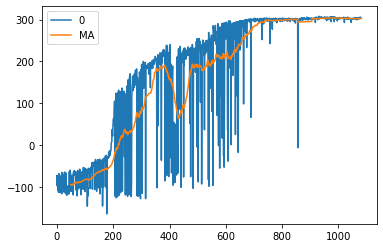

In [2]:
d.plot.line()

In [98]:
env.reset()
obs = env.reset()
done=False
while not done:   
    env.render()

    obs = torch.from_numpy(np.array([obs])).float().to(device)

    action, log_prob,value= model2.get_action(obs)
    obs,rew,done,_= env.step(action.flatten())  #[brain_name] 
    
env.reset()

KeyboardInterrupt: 